# Conclusion

Decision tree classification with kfolds=5, SMOTE oversampled, and pruned parameter values found with `RandomizedSearchCV`.

Worse results than guessing.


In [1]:
## Make width of notebook 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; // disable scrollable frames
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from datasets import data as Local ## Local module to get dataframes

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [4]:
games_df, winners_df, greater_fgp_df, greater_fg3_df, greater_ft_df, greater_ast_df, greater_reb_df, cumulative_stats_df, games_details_df, teams_df, players_df, ranking_df = \
    Local.get_all_dataset_dataframes('../../datasets/')

# Target datasets

- Home has:
    - 59.1% Winrate
    - 55.0% Rate of Higher FGP
    - 50.8% Rate of Higher FG3
    - 49.5% Rate of Higher FTP
    - 55.0% Rate of Higher AST
    - 53.4% Rate of Higher REB

In [5]:
winners_df # Whether the home team won in a game in each row of `games_df`

16157    1
16156    1
16155    1
16154    1
16153    1
        ..
4        0
3        0
2        0
1        1
0        1
Name: HOME_TEAM_WINS, Length: 23520, dtype: int64

In [6]:
winners_df.describe()

count    23520.000000
mean         0.591029
std          0.491654
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_TEAM_WINS, dtype: float64

In [7]:
greater_fgp_df.describe()

count    23520.000000
mean         0.550468
std          0.497457
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FG_PCT, dtype: float64

In [8]:
greater_fg3_df.describe()

count    23520.000000
mean         0.507993
std          0.499947
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FG3_PCT, dtype: float64

In [9]:
greater_ft_df.describe()

count    23520.000000
mean         0.494855
std          0.499984
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_FT_PCT, dtype: float64

In [10]:
greater_ast_df.describe()

count    23520.000000
mean         0.550128
std          0.497491
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_AST, dtype: float64

In [11]:
greater_reb_df.describe()

count    23520.000000
mean         0.533886
std          0.498861
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HOME_HIGHER_REB, dtype: float64

# Datasets

In [12]:
games_df

GAME_DATE_EST   GAME_ID  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  \
16157    2003-10-05  10300001    1610612762       1610612742    2003   
16156    2003-10-06  10300002    1610612763       1610612749    2003   
16155    2003-10-07  10300009    1610612758       1610612746    2003   
16154    2003-10-07  10300005    1610612757       1610612745    2003   
16153    2003-10-07  10300007    1610612748       1610612755    2003   
...             ...       ...           ...              ...     ...   
4        2020-12-18  12000040    1610612761       1610612748    2020   
3        2020-12-18  12000039    1610612754       1610612755    2020   
2        2020-12-19  12000049    1610612763       1610612737    2020   
1        2020-12-19  12000048    1610612764       1610612765    2020   
0        2020-12-19  12000047    1610612753       1610612766    2020   

       PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  REB_home  \
16157      90.0        0.457        0.735         0.143      23.0      41.0   
16156     105.0        0.494        0.618         0.267      25.0      48.0   
16155     101.0        0.467        0.871         0.444      19.0      39.0   
16154     104.0        0.527        0.657         0.429      22.0      33.0   
16153      86.0        0.352        0.647         0.222      15.0      55.0   
...         ...          ...          ...           ...       ...       ...   
4         105.0        0.380        0.737         0.356      27.0      37.0   
3         107.0        0.371        0.692         0.262      19.0      45.0   
2         116.0        0.400        0.744         0.396      21.0      43.0   
1          99.0        0.427        0.625         0.295      24.0      45.0   
0         120.0        0.433        0.792         0.425      23.0      50.0   

       PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  REB_away  
16157      85.0        0.447        0.500         0.250      20.0      38.0  
16156      94.0        0.427        0.700         0.154      20.0      43.0  
16155      82.0        0.368        0.609         0.364      13.0      50.0  
16154      80.0        0.470        0.667         0.333      10.0      37.0  
16153      79.0        0.329        0.897         0.143       7.0      44.0  
...         ...          ...          ...           ...       ...       ...  
4         117.0        0.534        0.741         0.514      30.0      51.0  
3         113.0        0.533        0.629         0.355      23.0      48.0  
2         117.0        0.422        0.837         0.297      24.0      47.0  
1          96.0        0.402        0.647         0.326      18.0      51.0  
0         117.0        0.444        0.864         0.439      21.0      52.0  

[23520 rows x 17 columns]

In [13]:
cumulative_stats_df

DATE   GAME_ID  SEASON_TYPE  SEASON  GAMES_PLAYED_home  \
0      2003-10-05  10300001            1    2003                  0   
1      2003-10-06  10300002            1    2003                  0   
2      2003-10-07  10300009            1    2003                  0   
3      2003-10-07  10300005            1    2003                  0   
4      2003-10-07  10300007            1    2003                  0   
...           ...       ...          ...     ...                ...   
23515  2020-12-18  12000040            1    2020                  2   
23516  2020-12-18  12000039            1    2020                  2   
23517  2020-12-19  12000049            1    2020                  3   
23518  2020-12-19  12000048            1    2020                  2   
23519  2020-12-19  12000047            1    2020                  3   

       GAMES_PLAYED_away  PPG_total_home  FG_PCT_total_home  \
0                      0        0.000000           0.000000   
1                      0        0.000000           0.000000   
2                      0        0.000000           0.000000   
3                      0        0.000000           0.000000   
4                      0        0.000000           0.000000   
...                  ...             ...                ...   
23515                  1      111.500000           0.443500   
23516                  1      105.000000           0.438000   
23517                  3      119.333333           0.466667   
23518                  3      100.000000           0.415000   
23519                  3      112.666667           0.444333   

       FG3_PCT_total_home  FT_PCT_total_home  ...  PPG_total_away  \
0                0.000000           0.000000  ...        0.000000   
1                0.000000           0.000000  ...        0.000000   
2                0.000000           0.000000  ...        0.000000   
3                0.000000           0.000000  ...        0.000000   
4                0.000000           0.000000  ...        0.000000   
...                   ...                ...  ...             ...   
23515            0.353000           0.691000  ...       92.000000   
23516            0.383000           0.619000  ...      108.000000   
23517            0.329333           0.704667  ...      111.333333   
23518            0.321500           0.704500  ...       93.333333   
23519            0.305333           0.758000  ...      110.666667   

       FG_PCT_total_away  FG3_PCT_total_away  FT_PCT_total_away  \
0               0.000000            0.000000           0.000000   
1               0.000000            0.000000           0.000000   
2               0.000000            0.000000           0.000000   
3               0.000000            0.000000           0.000000   
4               0.000000            0.000000           0.000000   
...                  ...                 ...                ...   
23515           0.427000            0.283000           0.818000   
23516           0.471000            0.241000           0.750000   
23517           0.392667            0.332333           0.789667   
23518           0.413333            0.333000           0.713000   
23519           0.442333            0.372333           0.751000   

       APG_total_away  RPG_total_away  TEAM_ID_away  TEAM_ID_home  W_PCT_away  \
0            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
1            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
2            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
3            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
4            0.000000        0.000000  1.610613e+09  1.610613e+09    0.000000   
...               ...             ...           ...           ...         ...   
23515       26.000000       35.000000  1.610613e+09  1.610613e+09    0.000000   
23516       23.000000       42.000000  1.610613e+09  1.610613e+09    1.000000   
23517       24.000000       56.000000  1

## Attach target columns to dataset

In [14]:
cumulative_stats_copy_df = cumulative_stats_df.copy()
cumulative_stats_copy_df['home_win'] = winners_df
cumulative_stats_copy_df['greater_fgp'] = greater_fgp_df
cumulative_stats_copy_df['greater_fg3'] = greater_fg3_df
cumulative_stats_copy_df['greater_ft'] = greater_ft_df
cumulative_stats_copy_df['greater_ast'] = greater_ast_df
cumulative_stats_copy_df['greater_reb'] = greater_reb_df

## Remove rows w/o data

In [15]:
cumulative_stats_copy_df = cumulative_stats_copy_df[(cumulative_stats_copy_df['GAMES_PLAYED_home']>0) & (cumulative_stats_copy_df['GAMES_PLAYED_away']>0)]

# Get new target datasets after row removal
winners_df = cumulative_stats_copy_df['home_win']
greater_fgp_df = cumulative_stats_copy_df['greater_fgp']
greater_fg3_df = cumulative_stats_copy_df['greater_fg3']
greater_ft_df = cumulative_stats_copy_df['greater_ft']
greater_ast_df = cumulative_stats_copy_df['greater_ast']
greater_reb_df = cumulative_stats_copy_df['greater_reb']

## Remove non-data

In [16]:
# Delete non-data
for key in [
    'DATE','GAME_ID','TEAM_ID_home','TEAM_ID_away','SEASON_TYPE','SEASON','GAMES_PLAYED_home','GAMES_PLAYED_away',
    'home_win','greater_fgp','greater_fg3','greater_ft','greater_ast','greater_reb'
]:
    del cumulative_stats_copy_df[key]
# Only look at home teams
# cumulative_stats_copy_df = cumulative_stats_copy_df.loc[cumulative_stats_copy_df['AT_HOME']==True]
# del cumulative_stats_copy_df['AT_HOME']
cumulative_stats_copy_df

PPG_total_home  FG_PCT_total_home  FG3_PCT_total_home  \
19         104.000000           0.527000            0.429000   
21          86.000000           0.380000            0.188000   
22          86.000000           0.352000            0.222000   
23          58.000000           0.457000            0.667000   
24          87.500000           0.432000            0.420000   
...               ...                ...                 ...   
23515      111.500000           0.443500            0.353000   
23516      105.000000           0.438000            0.383000   
23517      119.333333           0.466667            0.329333   
23518      100.000000           0.415000            0.321500   
23519      112.666667           0.444333            0.305333   

       FT_PCT_total_home  APG_total_home  RPG_total_home  PPG_total_away  \
19              0.657000       22.000000       33.000000      101.000000   
21              0.852000       19.000000       37.000000      101.000000   
22              0.647000       15.000000       55.000000       80.000000   
23              0.700000       10.000000       31.000000       89.000000   
24              0.672000       20.500000       43.000000       79.000000   
...                  ...             ...             ...             ...   
23515           0.691000       25.000000       41.500000       92.000000   
23516           0.619000       26.000000       35.500000      108.000000   
23517           0.704667       30.666667       52.666667      111.333333   
23518           0.704500       22.000000       44.500000       93.333333   
23519           0.758000       25.000000       51.333333      110.666667   

       FG_PCT_total_away  FG3_PCT_total_away  FT_PCT_total_away  \
19              0.467000            0.444000           0.871000   
21              0.464000            0.250000           0.679000   
22              0.350000            0.429000           0.750000   
23              0.462000            0.214000           0.538000   
24              0.329000            0.143000           0.897000   
...                  ...                 ...                ...   
23515           0.427000            0.283000           0.818000   
23516           0.471000            0.241000           0.750000   
23517           0.392667            0.332333           0.789667   
23518           0.413333            0.333000           0.713000   
23519           0.442333            0.372333           0.751000   

       APG_total_away  RPG_total_away  W_PCT_away  W_PCT_home  
19          19.000000       39.000000    1.000000    1.000000  
21          22.000000       47.000000    1.000000    0.000000  
22          18.000000       45.000000    0.000000    1.000000  
23          21.000000       36.000000    0.000000    0.000000  
24           7.000000       44.000000    0.000000    0.500000  
...               ...             ...         ...         ...  
23515       26.000000       35.000000    0.000000    1.000000  
23516       23.000000       42.000000    1.000000    0.000000  
23517       24.000000       56.000000    0.333333    1.000000  
23518       20.000000       41.666667    0.666667    0.000000  
23519       29.666667       45.000000    0.333333    0.333333  

[23147 rows x 14 columns]

## Do hyperparameters searches

In [17]:
from sklearn.metrics import classification_report

In [18]:
from sklearn.tree import plot_tree
from yellowbrick.model_selection import FeatureImportances

In [19]:
from sklearn.utils.class_weight import compute_sample_weight

In [20]:
# Get best params based from CV function
def do_cv(classifier, cv_fun, params, x, y, **kwargs):
    clf = cv_fun(
        classifier,
        params,
        scoring='accuracy', # Optimize for the 'accuracy' score of the model.
        **kwargs,
    )
#     clf.fit(x, y, sample_weight=compute_sample_weight('balanced',y))
    clf.fit(x, y)
    return clf

## Plot feature importances

In [21]:
def plot_feature_importances(clf, X, y):
    viz = FeatureImportances(clf, labels=X.columns)
    viz.fit(X, y)
    viz.show()

In [22]:
def print_all_metrics_and_plot(clf, X_train_dict, X_test_dict, y_train_dict, y_test_dict, grid_cv_params):
    scores = []
    for key in X_train_dict.keys():
        cv_clf = do_cv(
            clf,
#             GridSearchCV,
            RandomizedSearchCV,
            grid_cv_params,
            X_train_dict[key],
            y_train_dict[key],
        )
        print(key.upper()+':\n')
        score = cv_clf.best_estimator_.score(X_test_dict[key], y_test_dict[key])
        scores.append(score)
        print('Best decision tree accuracy (%s): %.2f' % (str(cv_clf.best_params_), score))
        print(classification_report(y_test_dict[key], cv_clf.best_estimator_.predict(X_test_dict[key])))
        plot_feature_importances(cv_clf.best_estimator_, X_train_dict[key], y_train_dict[key])
        print('---------------------------------------------')
    return scores

## Build K-folds datasets

In [23]:
from imblearn.over_sampling import SMOTE

In [24]:
from sklearn.model_selection import KFold
kf = KFold(shuffle=True, random_state=123)

X_train_dicts = []
X_test_dicts = []
y_train_dicts = []
y_test_dicts = []

for target, key in [(winners_df, 'winner'), (greater_fgp_df, 'fgp'), (greater_fg3_df, 'fg3'), (greater_ft_df, 'ft'), (greater_ast_df, 'ast'), (greater_reb_df, 'reb')]:
    X_over, y_over = SMOTE(sampling_strategy='minority').fit_resample(cumulative_stats_copy_df, target)
    for train, test in kf.split(X_over, y_over):
        X_train_dict = {}
        X_test_dict = {}
        y_train_dict = {}
        y_test_dict = {}
        
        X_train_dict[key], X_test_dict[key] = X_over.iloc[train], X_over.iloc[test]
        y_train_dict[key], y_test_dict[key] = y_over.iloc[train], y_over.iloc[test]
        
        X_train_dicts.append(X_train_dict)
        X_test_dicts.append(X_test_dict)
        y_train_dicts.append(y_train_dict)
        y_test_dicts.append(y_test_dict)

assert len(X_train_dicts)==len(X_test_dicts)==len(y_train_dicts)==len(y_test_dicts)
print(len(X_train_dicts))

30


In [25]:
def print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, params):
    scores=[]
    for i in range(len(X_train_dicts)):
        print(f'i={i}')
        score = print_all_metrics_and_plot(
            DecisionTreeClassifier(random_state=0),
            X_train_dicts[i],
            X_test_dicts[i],
            y_train_dicts[i],
            y_test_dicts[i],
            params,
        )
        if (i+1)%5==0:
            scores = pd.DataFrame(np.array(scores))
            print(f'Mean accuracy: {scores.mean()[0]}')
            print(f'Max accuracy: {scores.max()[0]}')
            print(f'Min accuracy: {scores.min()[0]}')
            print('=========================================')
            scores=[]
        else:
            scores += score

## Train decision tree w/o pruning

i=0


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.55
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      2695
           1       0.56      0.55      0.55      2789

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



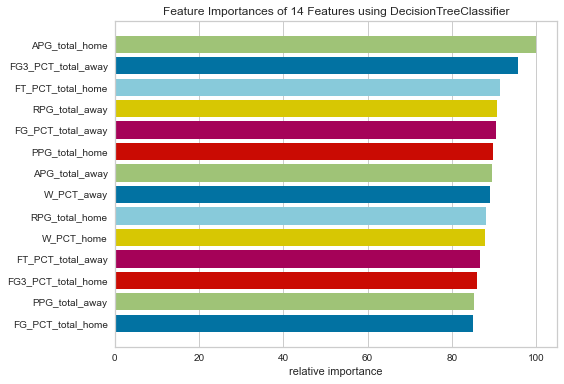

---------------------------------------------
i=1


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini'}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2780
           1       0.54      0.53      0.54      2704

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



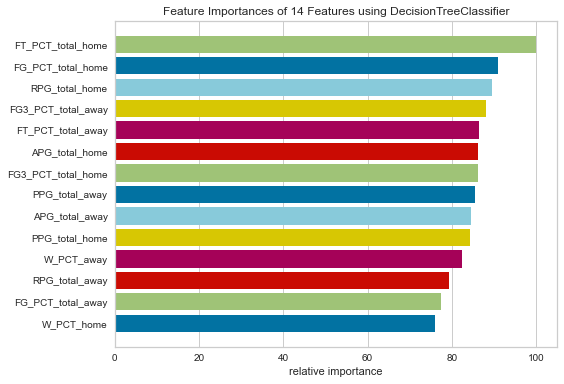

---------------------------------------------
i=2


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.55
              precision    recall  f1-score   support

           0       0.54      0.56      0.55      2727
           1       0.55      0.54      0.55      2757

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



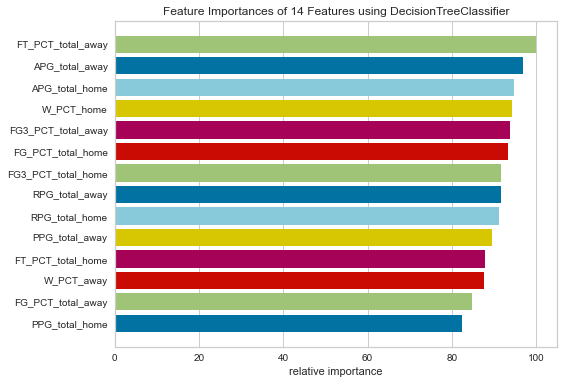

---------------------------------------------
i=3


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      2715
           1       0.55      0.54      0.54      2768

    accuracy                           0.54      5483
   macro avg       0.54      0.54      0.54      5483
weighted avg       0.54      0.54      0.54      5483



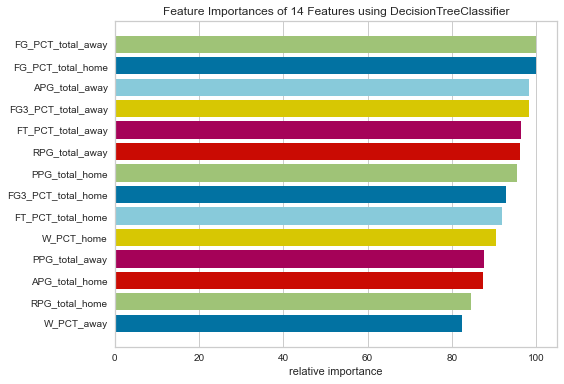

---------------------------------------------
i=4


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.55      0.56      0.55      2792
           1       0.54      0.53      0.53      2691

    accuracy                           0.54      5483
   macro avg       0.54      0.54      0.54      5483
weighted avg       0.54      0.54      0.54      5483



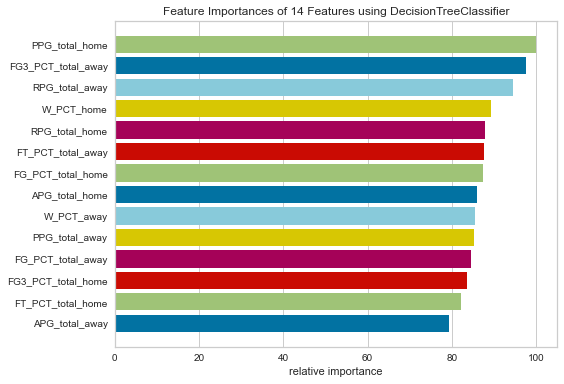

---------------------------------------------
Mean accuracy: 0.548529550857614
Max accuracy: 0.5532458059810358
Min accuracy: 0.544227612620828
i=5


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.53
              precision    recall  f1-score   support

           0       0.54      0.55      0.55      2614
           1       0.52      0.52      0.52      2495

    accuracy                           0.53      5109
   macro avg       0.53      0.53      0.53      5109
weighted avg       0.53      0.53      0.53      5109



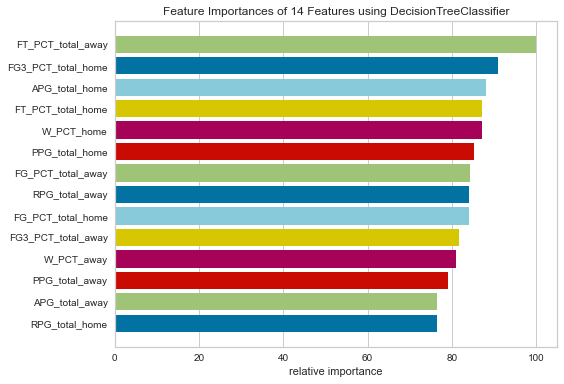

---------------------------------------------
i=6


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'gini'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2571
           1       0.53      0.53      0.53      2538

    accuracy                           0.53      5109
   macro avg       0.53      0.53      0.53      5109
weighted avg       0.53      0.53      0.53      5109



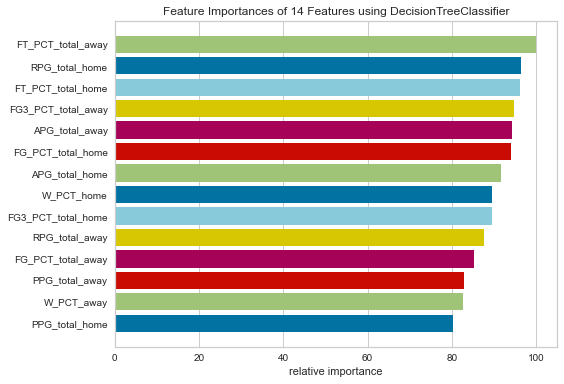

---------------------------------------------
i=7


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.55      0.55      2559
           1       0.54      0.52      0.53      2549

    accuracy                           0.54      5108
   macro avg       0.54      0.54      0.54      5108
weighted avg       0.54      0.54      0.54      5108



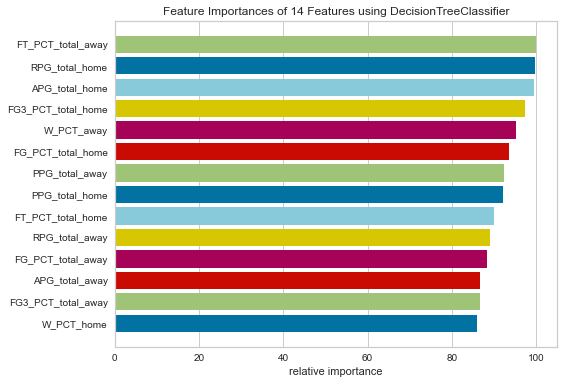

---------------------------------------------
i=8


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.53
              precision    recall  f1-score   support

           0       0.52      0.53      0.53      2470
           1       0.55      0.53      0.54      2638

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



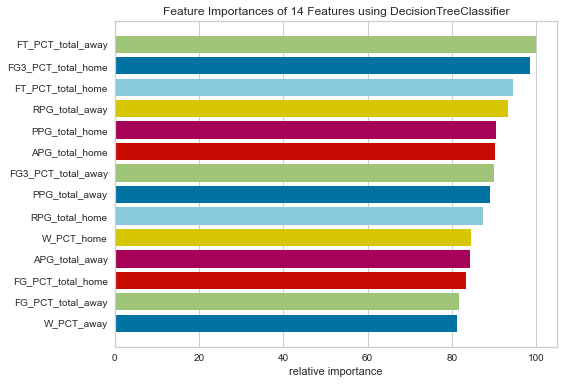

---------------------------------------------
i=9


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2557
           1       0.53      0.53      0.53      2551

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



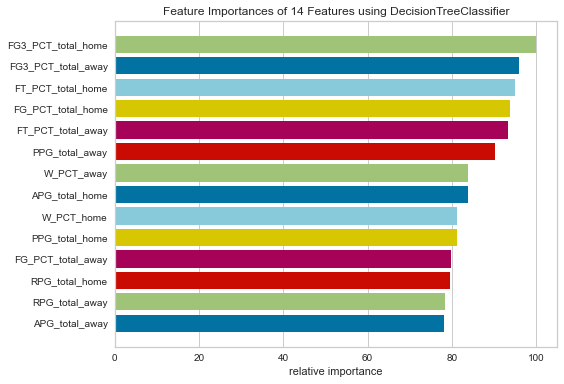

---------------------------------------------
Mean accuracy: 0.533522805042708
Max accuracy: 0.5379796397807362
Min accuracy: 0.528870620473674
i=10


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      2365
           1       0.50      0.50      0.50      2346

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



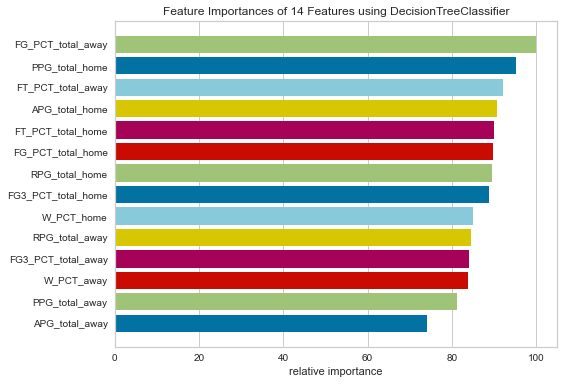

---------------------------------------------
i=11


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2402
           1       0.50      0.52      0.50      2309

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.51      0.50      0.50      4711



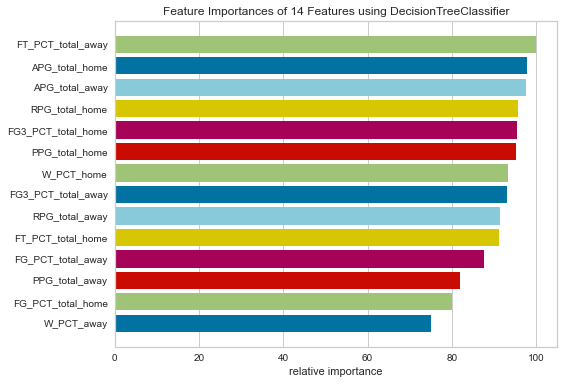

---------------------------------------------
i=12


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.49      0.52      0.51      2284
           1       0.52      0.49      0.50      2427

    accuracy                           0.50      4711
   macro avg       0.51      0.51      0.50      4711
weighted avg       0.51      0.50      0.50      4711



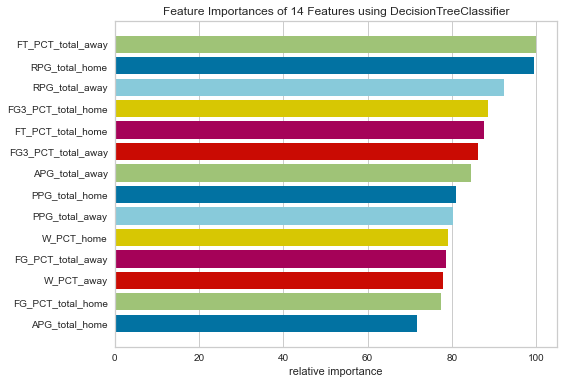

---------------------------------------------
i=13


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2307
           1       0.53      0.51      0.52      2404

    accuracy                           0.52      4711
   macro avg       0.52      0.52      0.52      4711
weighted avg       0.52      0.52      0.52      4711



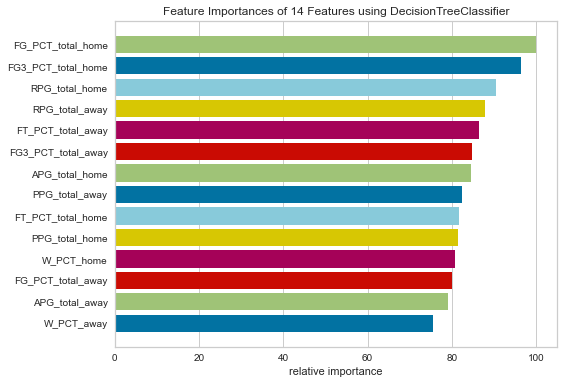

---------------------------------------------
i=14


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.52      0.48      0.50      2419
           1       0.49      0.52      0.50      2291

    accuracy                           0.50      4710
   macro avg       0.50      0.50      0.50      4710
weighted avg       0.50      0.50      0.50      4710



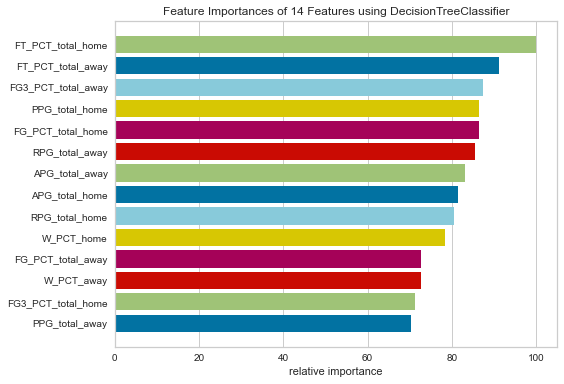

---------------------------------------------
Mean accuracy: 0.5066864784546805
Max accuracy: 0.5172999363192529
Min accuracy: 0.49968159626406283
i=15


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      2337
           1       0.50      0.52      0.51      2345

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



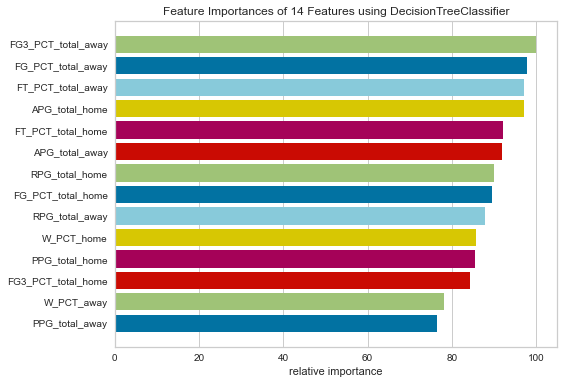

---------------------------------------------
i=16


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2322
           1       0.51      0.50      0.50      2360

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



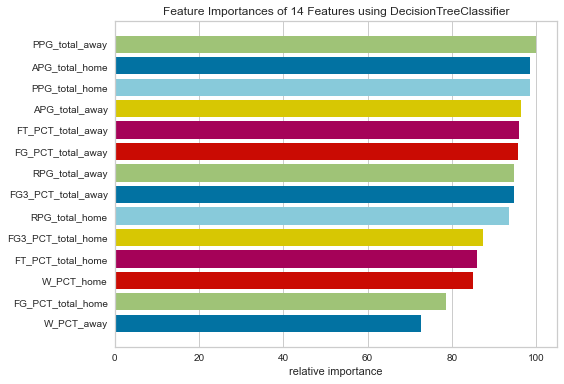

---------------------------------------------
i=17


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2360
           1       0.51      0.51      0.51      2322

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



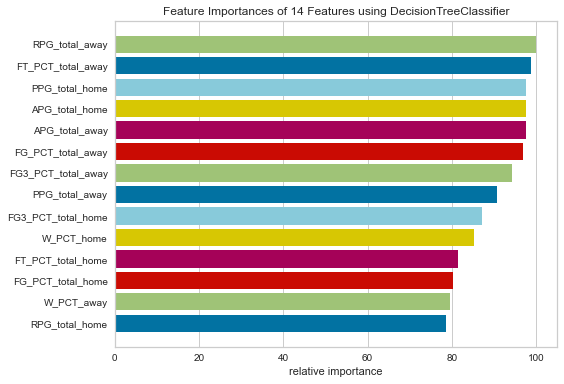

---------------------------------------------
i=18


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2343
           1       0.49      0.49      0.49      2339

    accuracy                           0.49      4682
   macro avg       0.49      0.49      0.49      4682
weighted avg       0.49      0.49      0.49      4682



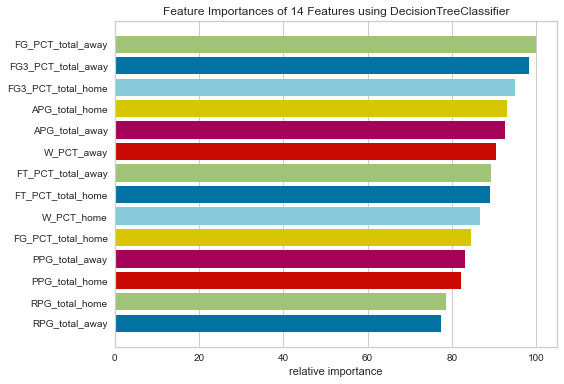

---------------------------------------------
i=19


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.52      0.52      2343
           1       0.51      0.51      0.51      2339

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



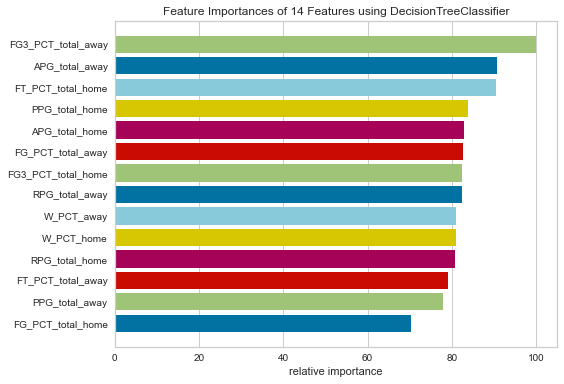

---------------------------------------------
Mean accuracy: 0.5020824434002563
Max accuracy: 0.5102520290474156
Min accuracy: 0.4910294745835113
i=20


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'gini'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2556
           1       0.53      0.54      0.53      2540

    accuracy                           0.53      5096
   macro avg       0.53      0.53      0.53      5096
weighted avg       0.53      0.53      0.53      5096



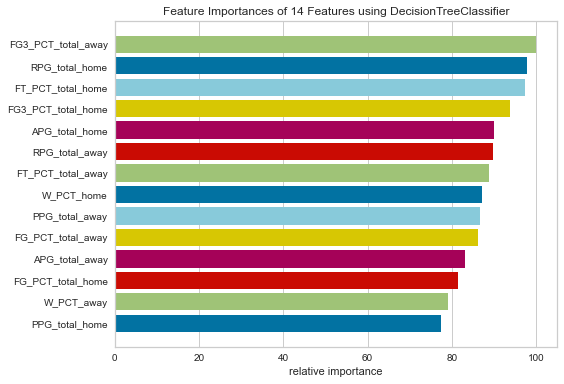

---------------------------------------------
i=21


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.55      0.56      0.55      2578
           1       0.54      0.53      0.53      2517

    accuracy                           0.54      5095
   macro avg       0.54      0.54      0.54      5095
weighted avg       0.54      0.54      0.54      5095



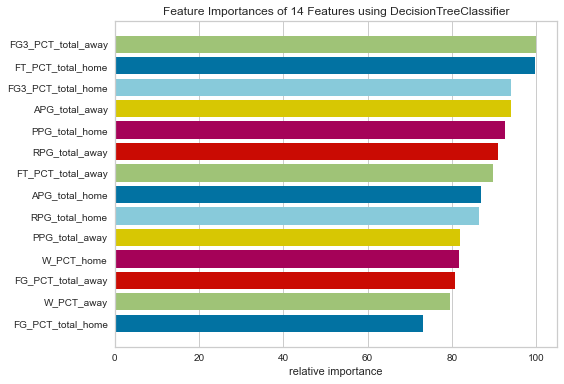

---------------------------------------------
i=22


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'entropy'}): 0.54
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2522
           1       0.55      0.53      0.54      2573

    accuracy                           0.54      5095
   macro avg       0.54      0.54      0.54      5095
weighted avg       0.54      0.54      0.54      5095



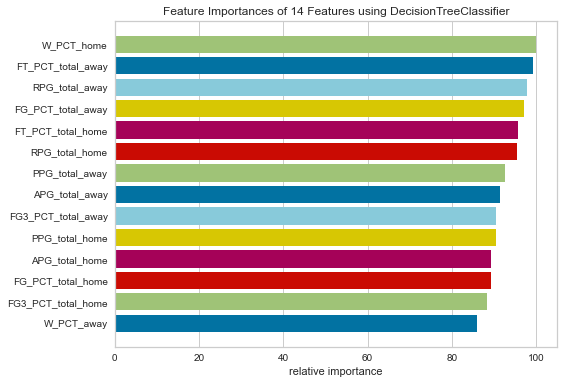

---------------------------------------------
i=23


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2531
           1       0.54      0.52      0.53      2564

    accuracy                           0.54      5095
   macro avg       0.54      0.54      0.53      5095
weighted avg       0.54      0.54      0.53      5095



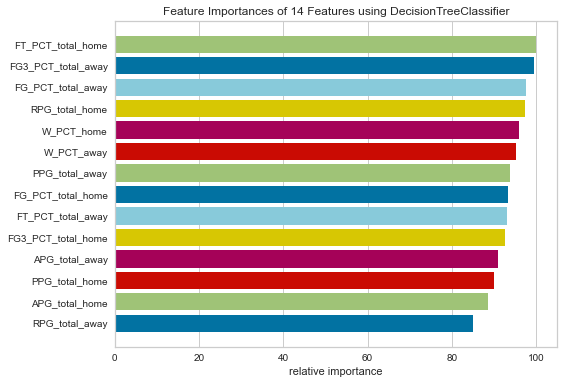

---------------------------------------------
i=24


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2551
           1       0.51      0.52      0.52      2544

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



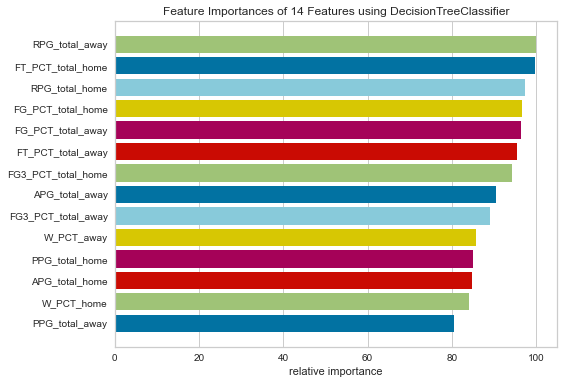

---------------------------------------------
Mean accuracy: 0.5372653685162447
Max accuracy: 0.5432777232580962
Min accuracy: 0.5317896389324961
i=25


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'gini'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      2470
           1       0.53      0.54      0.53      2475

    accuracy                           0.53      4945
   macro avg       0.53      0.53      0.53      4945
weighted avg       0.53      0.53      0.53      4945



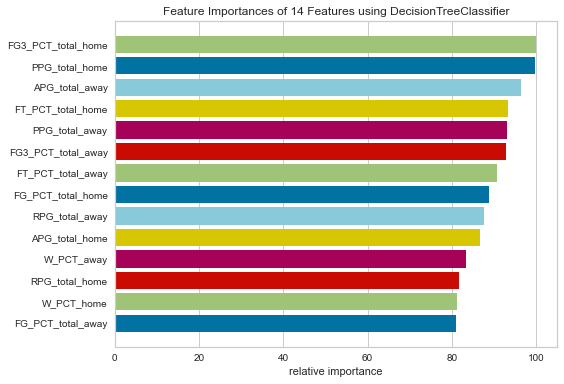

---------------------------------------------
i=26


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2413
           1       0.53      0.51      0.52      2532

    accuracy                           0.52      4945
   macro avg       0.52      0.52      0.52      4945
weighted avg       0.52      0.52      0.52      4945



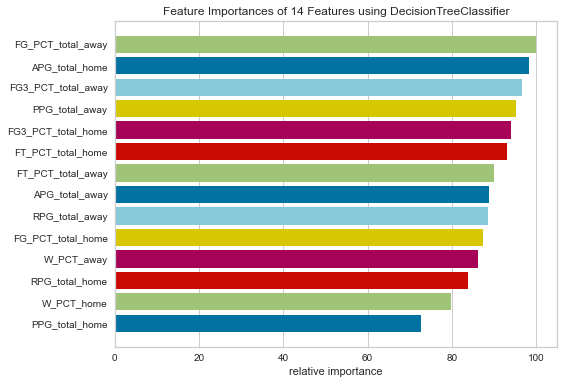

---------------------------------------------
i=27


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2479
           1       0.51      0.51      0.51      2465

    accuracy                           0.52      4944
   macro avg       0.52      0.52      0.52      4944
weighted avg       0.52      0.52      0.52      4944



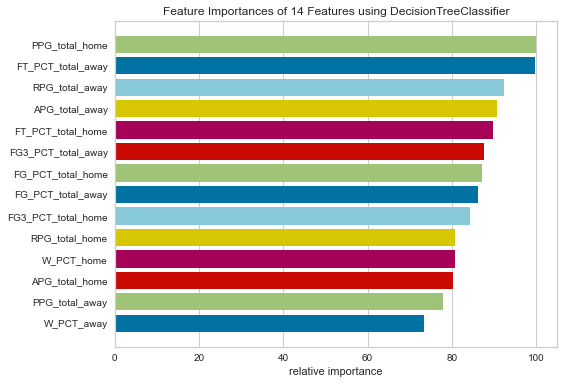

---------------------------------------------
i=28


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.54      0.53      2473
           1       0.52      0.51      0.52      2471

    accuracy                           0.52      4944
   macro avg       0.52      0.52      0.52      4944
weighted avg       0.52      0.52      0.52      4944



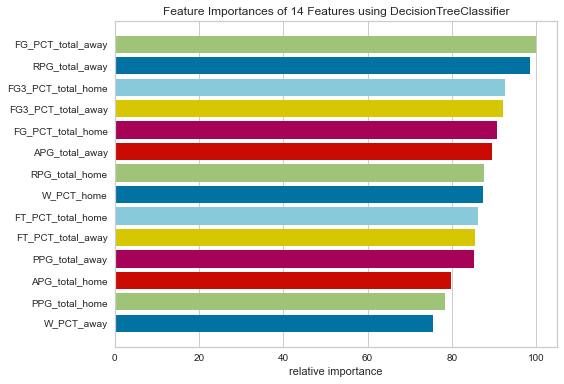

---------------------------------------------
i=29


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      2526
           1       0.51      0.52      0.52      2418

    accuracy                           0.52      4944
   macro avg       0.52      0.52      0.52      4944
weighted avg       0.52      0.52      0.52      4944



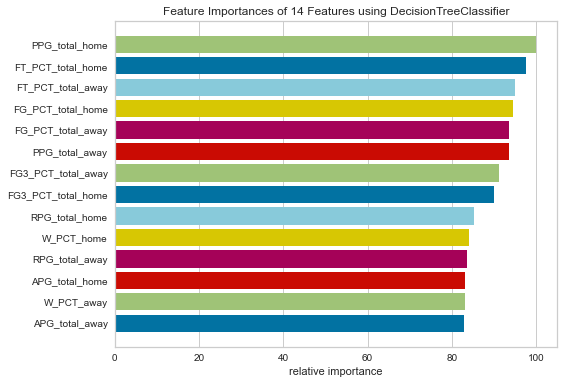

---------------------------------------------
Mean accuracy: 0.5219433080225523
Max accuracy: 0.5282103134479272
Min accuracy: 0.5155744336569579


In [26]:
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {'criterion':['gini','entropy']})

In [27]:
# plt.figure(figsize=(15,10))
# t = plot_tree(decision_tree_clf)

## Try prune max depth

i=0
WINNER:

Best decision tree accuracy ({'max_depth': 39, 'criterion': 'entropy'}): 0.55
              precision    recall  f1-score   support

           0       0.54      0.61      0.57      2695
           1       0.57      0.49      0.52      2789

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



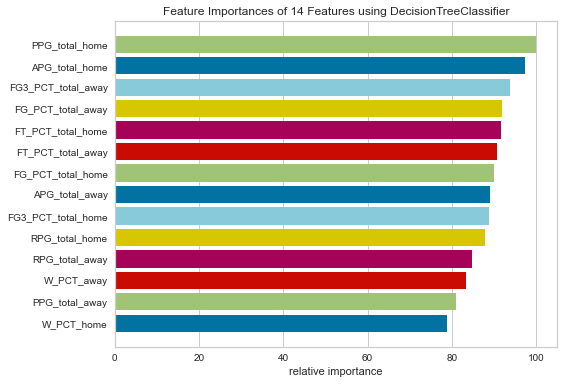

---------------------------------------------
i=1
WINNER:

Best decision tree accuracy ({'max_depth': 29, 'criterion': 'gini'}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.59      0.57      2780
           1       0.55      0.51      0.53      2704

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



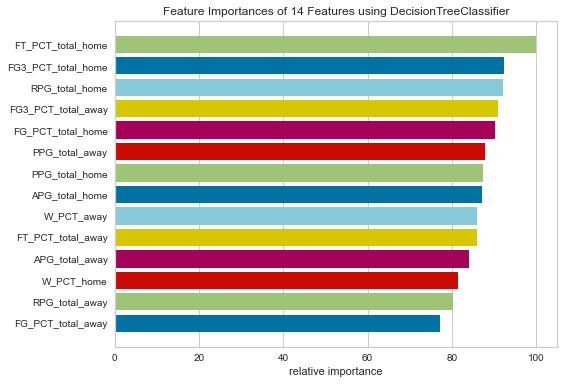

---------------------------------------------
i=2
WINNER:

Best decision tree accuracy ({'max_depth': 39, 'criterion': 'entropy'}): 0.55
              precision    recall  f1-score   support

           0       0.54      0.60      0.57      2727
           1       0.56      0.50      0.53      2757

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



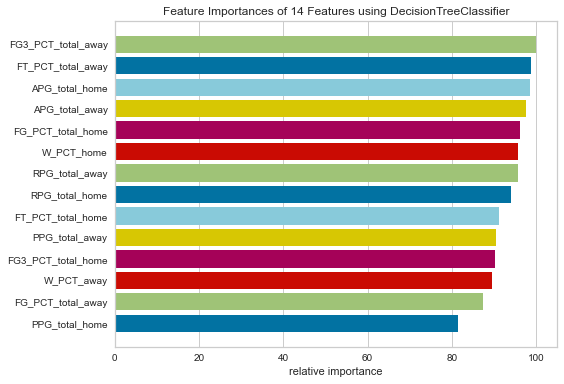

---------------------------------------------
i=3
WINNER:

Best decision tree accuracy ({'max_depth': 33, 'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.53      0.57      0.55      2715
           1       0.55      0.51      0.53      2768

    accuracy                           0.54      5483
   macro avg       0.54      0.54      0.54      5483
weighted avg       0.54      0.54      0.54      5483



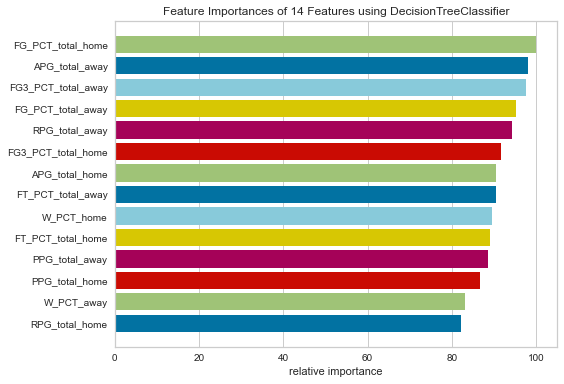

---------------------------------------------
i=4
WINNER:

Best decision tree accuracy ({'max_depth': 50, 'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.55      0.56      0.55      2792
           1       0.54      0.53      0.53      2691

    accuracy                           0.54      5483
   macro avg       0.54      0.54      0.54      5483
weighted avg       0.54      0.54      0.54      5483



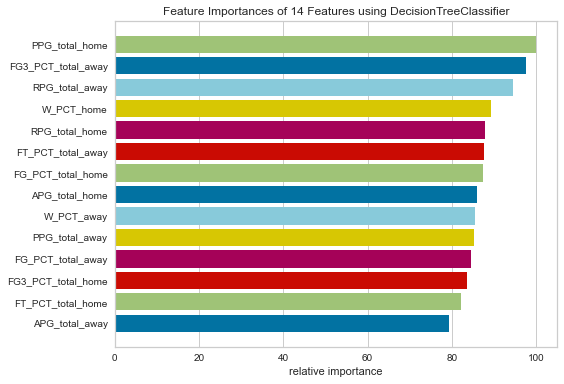

---------------------------------------------
Mean accuracy: 0.5475264420509092
Max accuracy: 0.5505105762217359
Min accuracy: 0.5400328287433886
i=5
FGP:

Best decision tree accuracy ({'max_depth': 46, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.52      0.53      2614
           1       0.51      0.52      0.52      2495

    accuracy                           0.52      5109
   macro avg       0.52      0.52      0.52      5109
weighted avg       0.52      0.52      0.52      5109



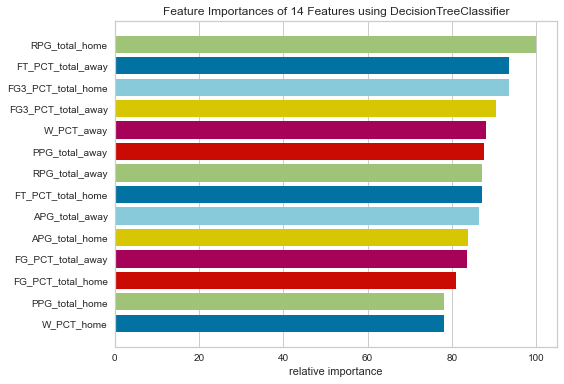

---------------------------------------------
i=6
FGP:

Best decision tree accuracy ({'max_depth': 53, 'criterion': 'gini'}): 0.53
              precision    recall  f1-score   support

           0       0.54      0.53      0.53      2571
           1       0.53      0.54      0.53      2538

    accuracy                           0.53      5109
   macro avg       0.53      0.53      0.53      5109
weighted avg       0.53      0.53      0.53      5109



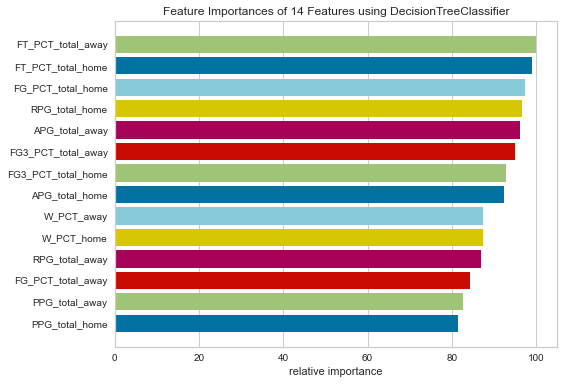

---------------------------------------------
i=7
FGP:

Best decision tree accuracy ({'max_depth': 50, 'criterion': 'entropy'}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      2559
           1       0.54      0.53      0.53      2549

    accuracy                           0.54      5108
   macro avg       0.54      0.54      0.54      5108
weighted avg       0.54      0.54      0.54      5108



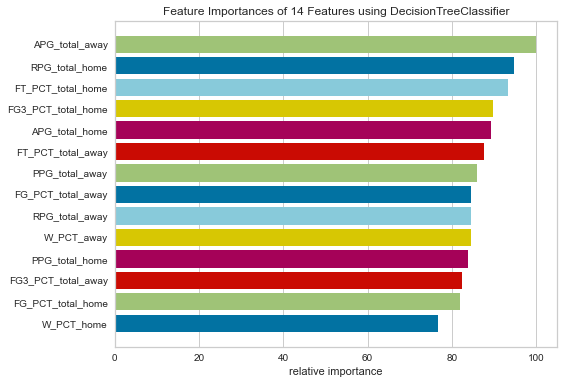

---------------------------------------------
i=8
FGP:

Best decision tree accuracy ({'max_depth': 41, 'criterion': 'entropy'}): 0.53
              precision    recall  f1-score   support

           0       0.51      0.54      0.53      2470
           1       0.55      0.52      0.53      2638

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



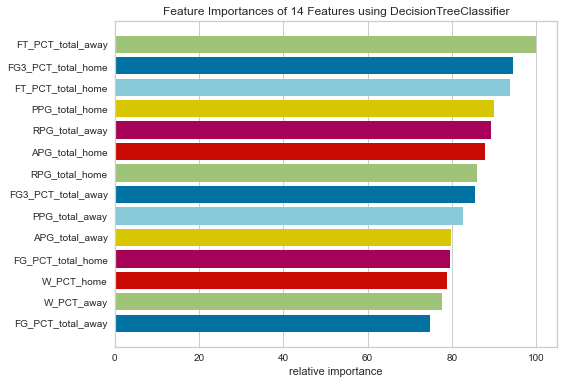

---------------------------------------------
i=9
FGP:

Best decision tree accuracy ({'max_depth': 51, 'criterion': 'entropy'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.56      0.54      2557
           1       0.53      0.50      0.52      2551

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



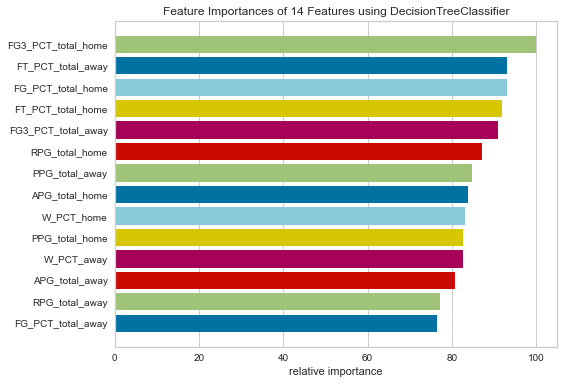

---------------------------------------------
Mean accuracy: 0.5297546570127524
Max accuracy: 0.5360219263899765
Min accuracy: 0.5212370326874144
i=10
FG3:

Best decision tree accuracy ({'max_depth': 25, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.40      0.44      2365
           1       0.49      0.59      0.54      2346

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.49      4711
weighted avg       0.50      0.50      0.49      4711



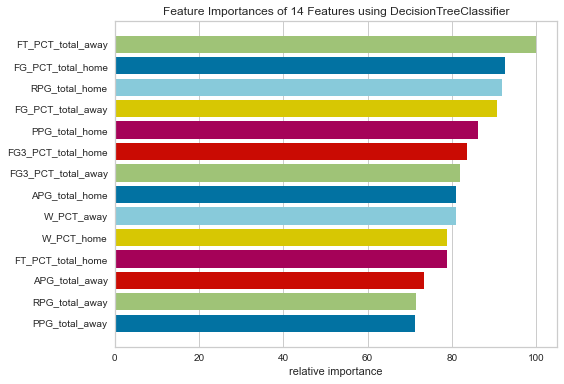

---------------------------------------------
i=11
FG3:

Best decision tree accuracy ({'max_depth': 46, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2402
           1       0.50      0.52      0.50      2309

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.51      0.50      0.50      4711



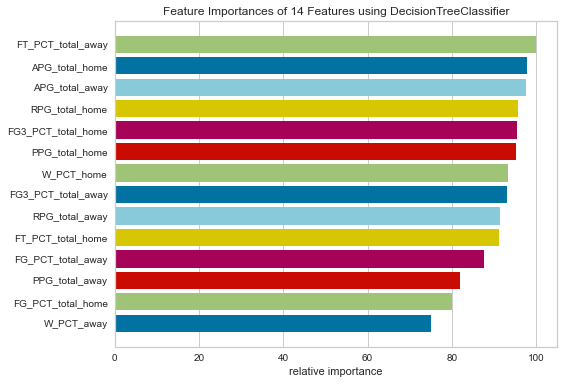

---------------------------------------------
i=12
FG3:

Best decision tree accuracy ({'max_depth': 29, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.49      0.51      0.50      2284
           1       0.52      0.50      0.51      2427

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



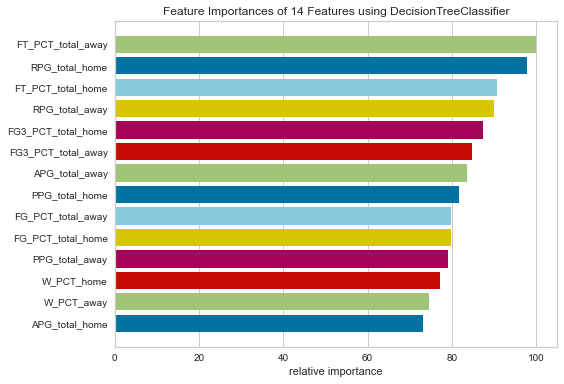

---------------------------------------------
i=13
FG3:

Best decision tree accuracy ({'max_depth': 56, 'criterion': 'entropy'}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2307
           1       0.53      0.51      0.52      2404

    accuracy                           0.52      4711
   macro avg       0.52      0.52      0.52      4711
weighted avg       0.52      0.52      0.52      4711



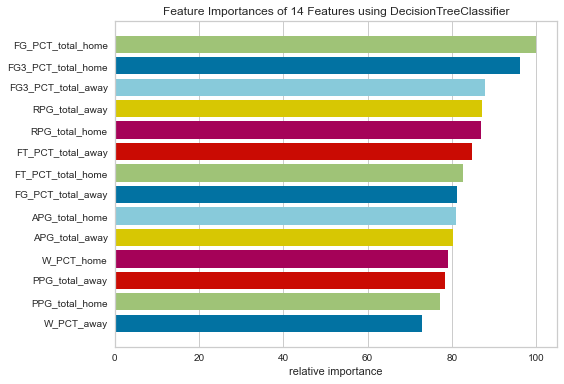

---------------------------------------------
i=14
FG3:

Best decision tree accuracy ({'max_depth': 44, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.52      0.49      0.50      2419
           1       0.49      0.52      0.51      2291

    accuracy                           0.50      4710
   macro avg       0.50      0.50      0.50      4710
weighted avg       0.50      0.50      0.50      4710



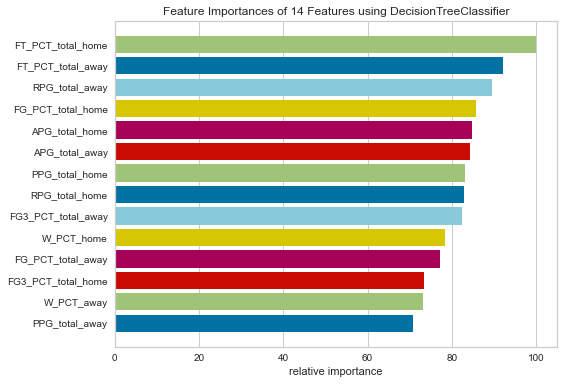

---------------------------------------------
Mean accuracy: 0.5059435364041605
Max accuracy: 0.5175122054765443
Min accuracy: 0.49501167480365105
i=15
FT:

Best decision tree accuracy ({'max_depth': 31, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.46      0.48      2337
           1       0.50      0.54      0.52      2345

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



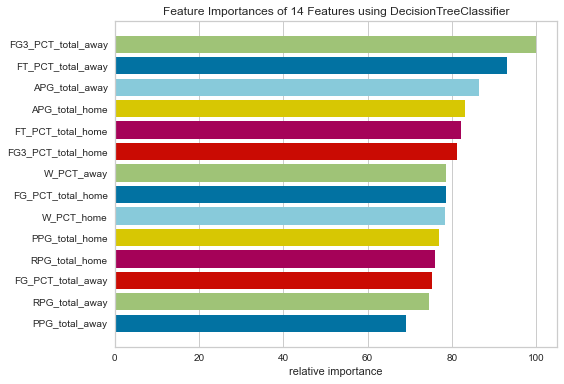

---------------------------------------------
i=16
FT:

Best decision tree accuracy ({'max_depth': 53, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2322
           1       0.51      0.50      0.51      2360

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



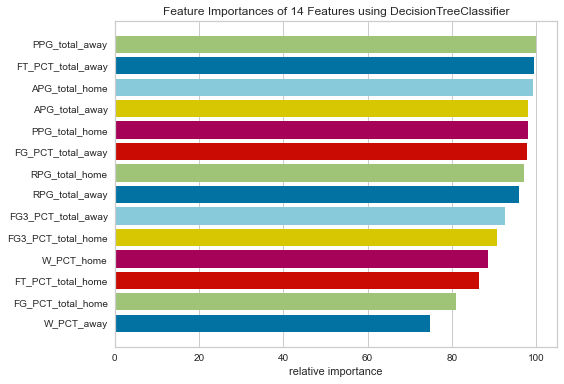

---------------------------------------------
i=17
FT:

Best decision tree accuracy ({'max_depth': 43, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2360
           1       0.51      0.52      0.51      2322

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



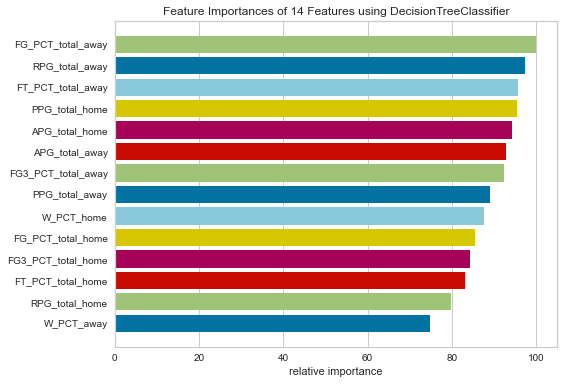

---------------------------------------------
i=18
FT:

Best decision tree accuracy ({'max_depth': 50, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      0.49      0.49      2343
           1       0.49      0.49      0.49      2339

    accuracy                           0.49      4682
   macro avg       0.49      0.49      0.49      4682
weighted avg       0.49      0.49      0.49      4682



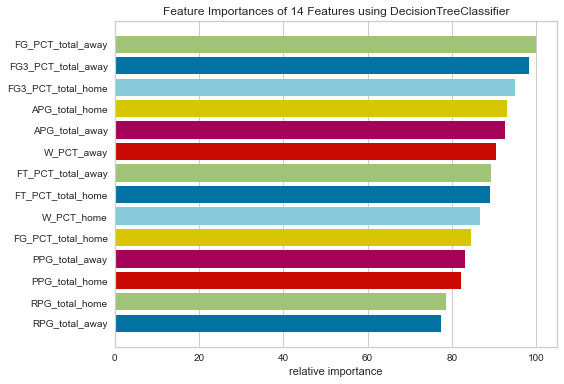

---------------------------------------------
i=19
FT:

Best decision tree accuracy ({'max_depth': 17, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.61      0.55      2343
           1       0.49      0.38      0.43      2339

    accuracy                           0.50      4682
   macro avg       0.49      0.50      0.49      4682
weighted avg       0.49      0.50      0.49      4682



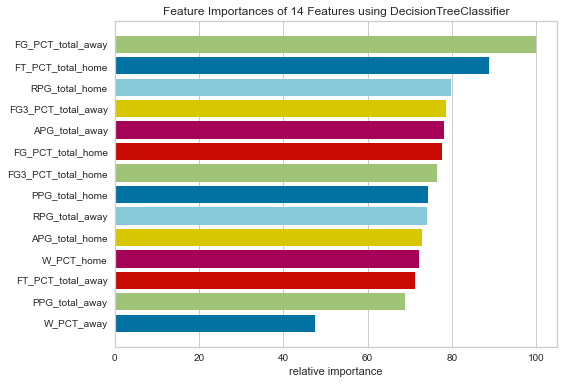

---------------------------------------------
Mean accuracy: 0.5008543357539513
Max accuracy: 0.5108927808628791
Min accuracy: 0.4910294745835113
i=20
AST:

Best decision tree accuracy ({'max_depth': 57, 'criterion': 'gini'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2556
           1       0.53      0.54      0.53      2540

    accuracy                           0.53      5096
   macro avg       0.53      0.53      0.53      5096
weighted avg       0.53      0.53      0.53      5096



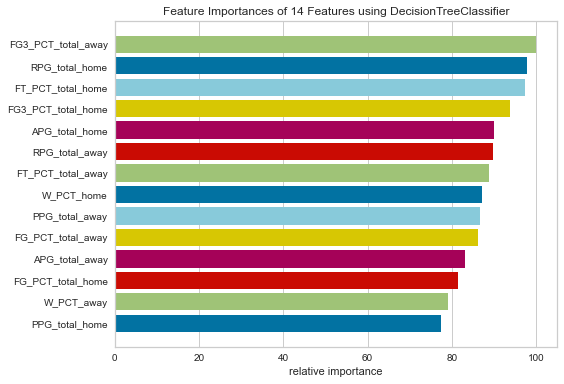

---------------------------------------------
i=21
AST:

Best decision tree accuracy ({'max_depth': 56, 'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.55      0.56      0.55      2578
           1       0.54      0.53      0.53      2517

    accuracy                           0.54      5095
   macro avg       0.54      0.54      0.54      5095
weighted avg       0.54      0.54      0.54      5095



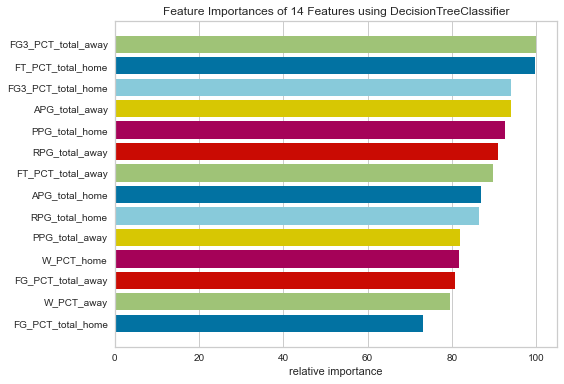

---------------------------------------------
i=22
AST:

Best decision tree accuracy ({'max_depth': 57, 'criterion': 'entropy'}): 0.54
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2522
           1       0.55      0.53      0.54      2573

    accuracy                           0.54      5095
   macro avg       0.54      0.54      0.54      5095
weighted avg       0.54      0.54      0.54      5095



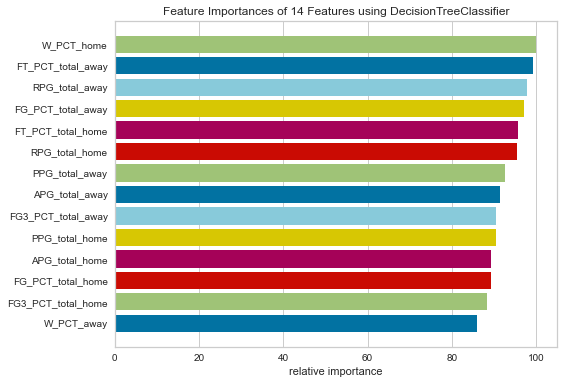

---------------------------------------------
i=23
AST:

Best decision tree accuracy ({'max_depth': 58, 'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2531
           1       0.54      0.52      0.53      2564

    accuracy                           0.54      5095
   macro avg       0.54      0.54      0.53      5095
weighted avg       0.54      0.54      0.53      5095



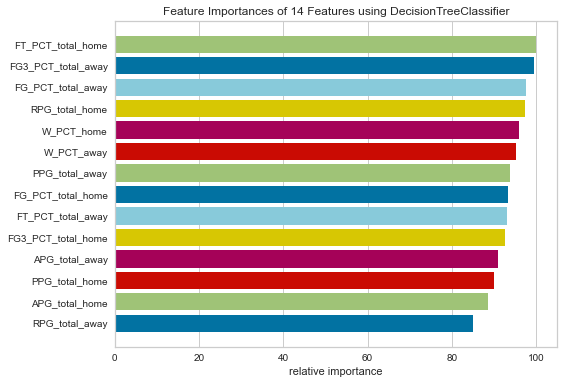

---------------------------------------------
i=24
AST:

Best decision tree accuracy ({'max_depth': 54, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2551
           1       0.51      0.52      0.52      2544

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



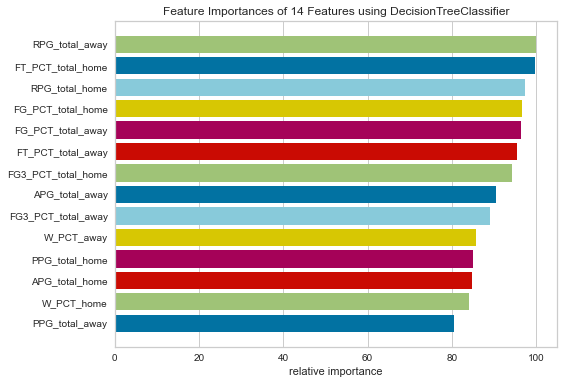

---------------------------------------------
Mean accuracy: 0.5372653685162447
Max accuracy: 0.5432777232580962
Min accuracy: 0.5317896389324961
i=25
REB:

Best decision tree accuracy ({'max_depth': 57, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.51      0.52      2470
           1       0.52      0.53      0.53      2475

    accuracy                           0.52      4945
   macro avg       0.52      0.52      0.52      4945
weighted avg       0.52      0.52      0.52      4945



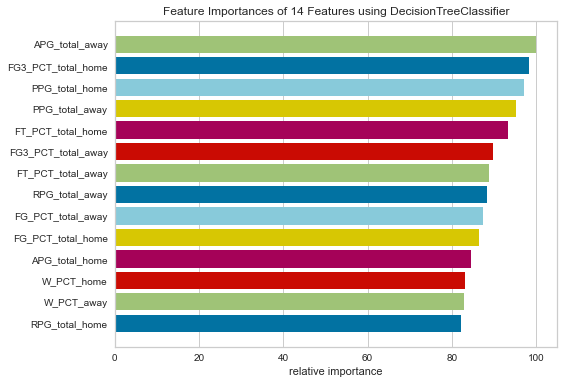

---------------------------------------------
i=26
REB:

Best decision tree accuracy ({'max_depth': 37, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.54      0.52      2413
           1       0.53      0.51      0.52      2532

    accuracy                           0.52      4945
   macro avg       0.52      0.52      0.52      4945
weighted avg       0.52      0.52      0.52      4945



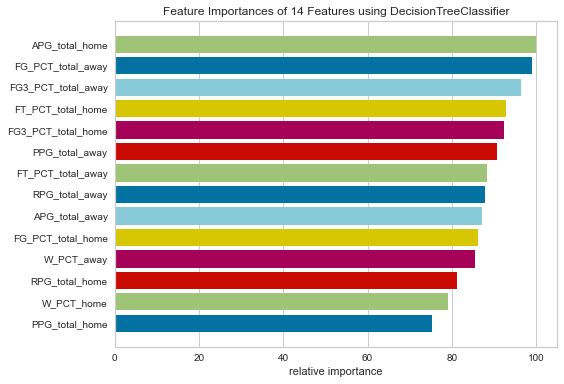

---------------------------------------------
i=27
REB:

Best decision tree accuracy ({'max_depth': 42, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      2479
           1       0.51      0.52      0.51      2465

    accuracy                           0.51      4944
   macro avg       0.51      0.51      0.51      4944
weighted avg       0.51      0.51      0.51      4944



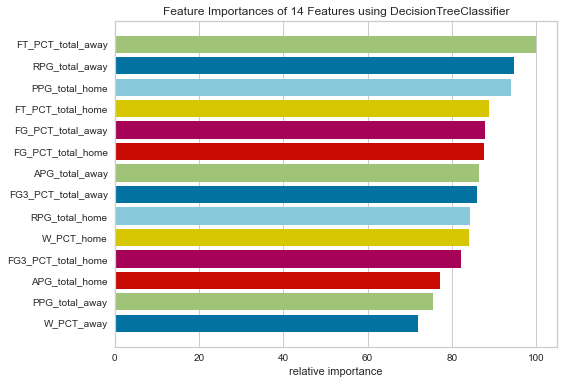

---------------------------------------------
i=28
REB:

Best decision tree accuracy ({'max_depth': 56, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2473
           1       0.50      0.49      0.49      2471

    accuracy                           0.50      4944
   macro avg       0.50      0.50      0.50      4944
weighted avg       0.50      0.50      0.50      4944



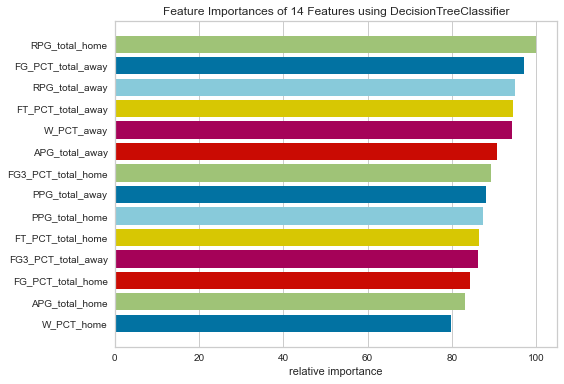

---------------------------------------------
i=29
REB:

Best decision tree accuracy ({'max_depth': 52, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.52      0.53      2526
           1       0.51      0.52      0.52      2418

    accuracy                           0.52      4944
   macro avg       0.52      0.52      0.52      4944
weighted avg       0.52      0.52      0.52      4944



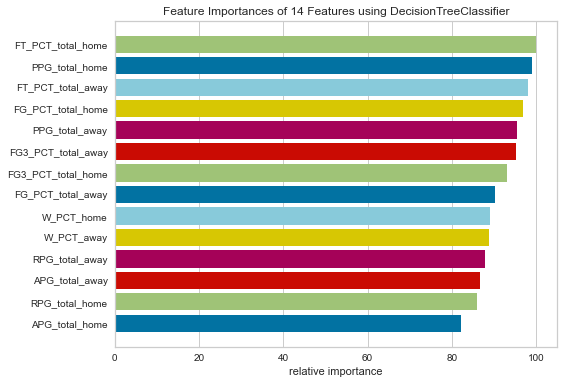

---------------------------------------------
Mean accuracy: 0.5131451529118033
Max accuracy: 0.5209302325581395
Min accuracy: 0.5022249190938511


In [28]:
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'max_depth': [*range(4,60)],
    'criterion': ['gini', 'entropy'],
})

## Try prune impurity decrease

i=0
WINNER:

Best decision tree accuracy ({'min_impurity_decrease': 0.1, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2695
           1       0.00      0.00      0.00      2789

    accuracy                           0.49      5484
   macro avg       0.25      0.50      0.33      5484
weighted avg       0.24      0.49      0.32      5484



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

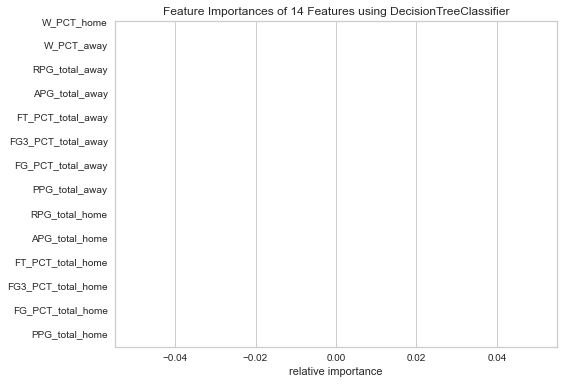

---------------------------------------------
i=1
WINNER:

Best decision tree accuracy ({'min_impurity_decrease': 0.4, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2780
           1       0.49      1.00      0.66      2704

    accuracy                           0.49      5484
   macro avg       0.25      0.50      0.33      5484
weighted avg       0.24      0.49      0.33      5484



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

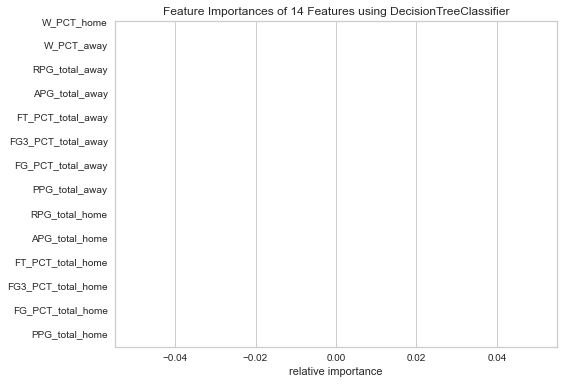

---------------------------------------------
i=2
WINNER:

Best decision tree accuracy ({'min_impurity_decrease': 0.05, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2727
           1       0.00      0.00      0.00      2757

    accuracy                           0.50      5484
   macro avg       0.25      0.50      0.33      5484
weighted avg       0.25      0.50      0.33      5484



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

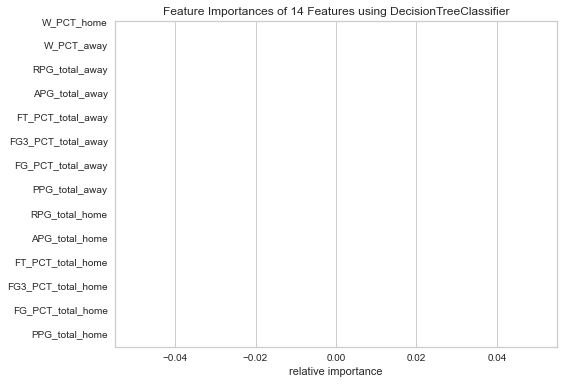

---------------------------------------------
i=3
WINNER:

Best decision tree accuracy ({'min_impurity_decrease': 0.7, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2715
           1       0.00      0.00      0.00      2768

    accuracy                           0.50      5483
   macro avg       0.25      0.50      0.33      5483
weighted avg       0.25      0.50      0.33      5483



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

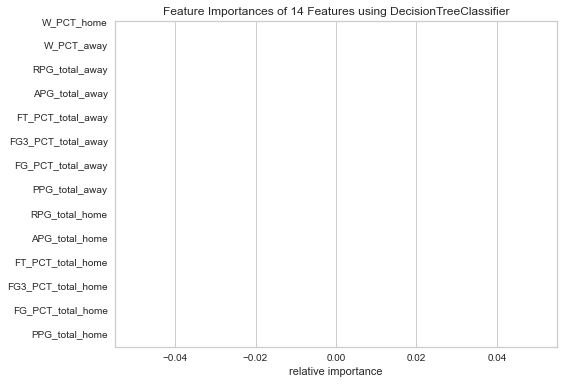

---------------------------------------------
i=4
WINNER:

Best decision tree accuracy ({'min_impurity_decrease': 0.55, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2792
           1       0.49      1.00      0.66      2691

    accuracy                           0.49      5483
   macro avg       0.25      0.50      0.33      5483
weighted avg       0.24      0.49      0.32      5483



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

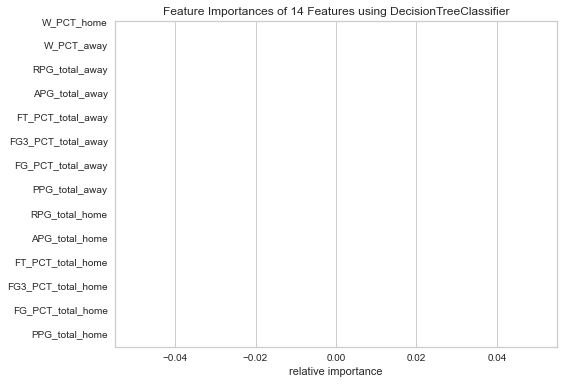

---------------------------------------------
Mean accuracy: 0.4942330035958901
Max accuracy: 0.4972647702407002
Min accuracy: 0.49142961342086067
i=5
FGP:

Best decision tree accuracy ({'min_impurity_decrease': 0.25, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2614
           1       0.49      1.00      0.66      2495

    accuracy                           0.49      5109
   macro avg       0.24      0.50      0.33      5109
weighted avg       0.24      0.49      0.32      5109



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

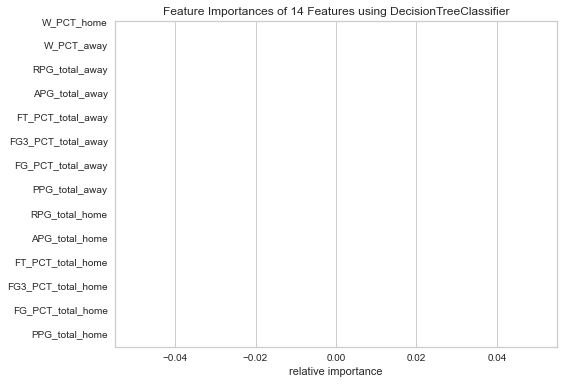

---------------------------------------------
i=6
FGP:

Best decision tree accuracy ({'min_impurity_decrease': 0.55, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2571
           1       0.50      1.00      0.66      2538

    accuracy                           0.50      5109
   macro avg       0.25      0.50      0.33      5109
weighted avg       0.25      0.50      0.33      5109



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

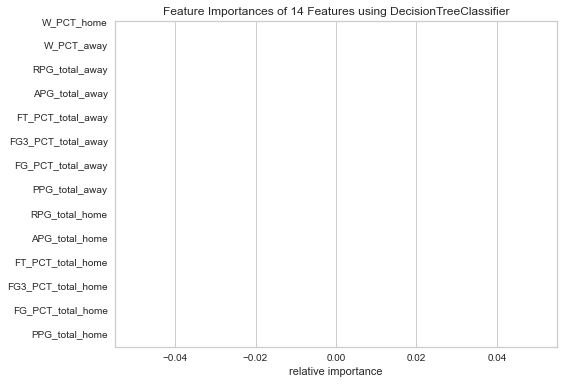

---------------------------------------------
i=7
FGP:

Best decision tree accuracy ({'min_impurity_decrease': 0.15, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2559
           1       0.50      1.00      0.67      2549

    accuracy                           0.50      5108
   macro avg       0.25      0.50      0.33      5108
weighted avg       0.25      0.50      0.33      5108



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

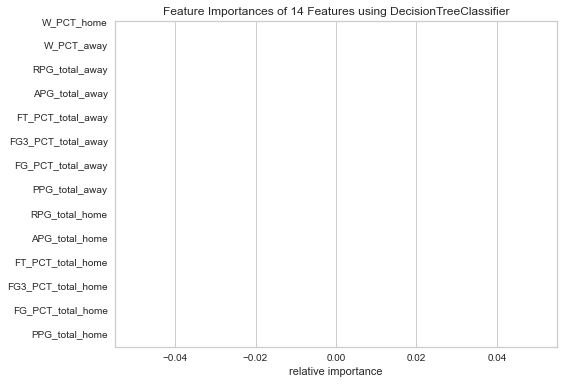

---------------------------------------------
i=8
FGP:

Best decision tree accuracy ({'min_impurity_decrease': 0.7, 'criterion': 'entropy'}): 0.48
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      2470
           1       0.00      0.00      0.00      2638

    accuracy                           0.48      5108
   macro avg       0.24      0.50      0.33      5108
weighted avg       0.23      0.48      0.32      5108



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

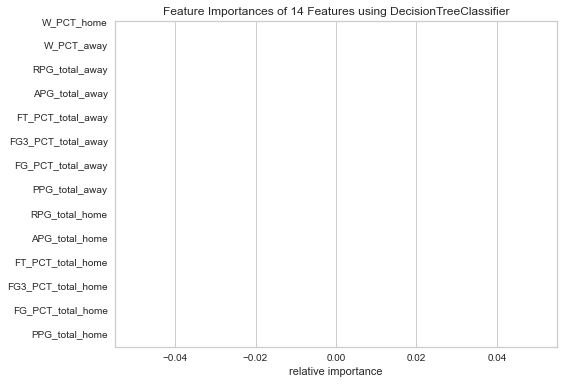

---------------------------------------------
i=9
FGP:

Best decision tree accuracy ({'min_impurity_decrease': 0.6, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2557
           1       0.50      1.00      0.67      2551

    accuracy                           0.50      5108
   macro avg       0.25      0.50      0.33      5108
weighted avg       0.25      0.50      0.33      5108



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

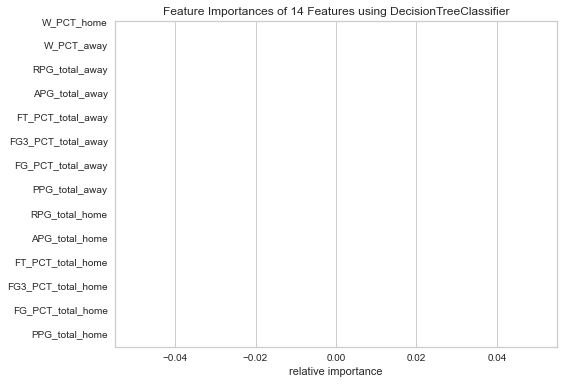

---------------------------------------------
Mean accuracy: 0.49192516032251044
Max accuracy: 0.4990211433046202
Min accuracy: 0.48355520751761943
i=10
FG3:

Best decision tree accuracy ({'min_impurity_decrease': 0.25, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2365
           1       0.50      1.00      0.66      2346

    accuracy                           0.50      4711
   macro avg       0.25      0.50      0.33      4711
weighted avg       0.25      0.50      0.33      4711



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

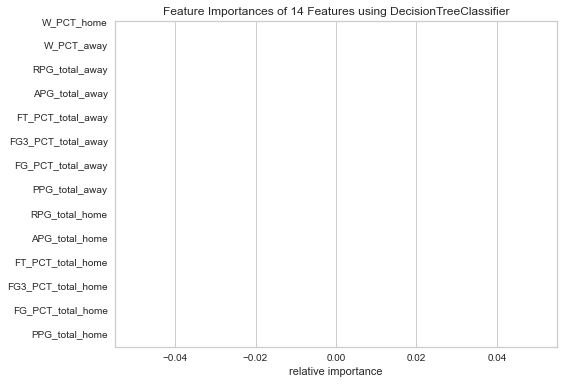

---------------------------------------------
i=11
FG3:

Best decision tree accuracy ({'min_impurity_decrease': 0.25, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2402
           1       0.49      1.00      0.66      2309

    accuracy                           0.49      4711
   macro avg       0.25      0.50      0.33      4711
weighted avg       0.24      0.49      0.32      4711



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

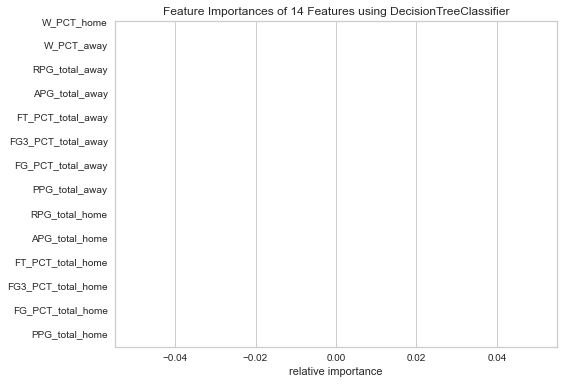

---------------------------------------------
i=12
FG3:

Best decision tree accuracy ({'min_impurity_decrease': 0.5, 'criterion': 'gini'}): 0.48
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      2284
           1       0.00      0.00      0.00      2427

    accuracy                           0.48      4711
   macro avg       0.24      0.50      0.33      4711
weighted avg       0.24      0.48      0.32      4711



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

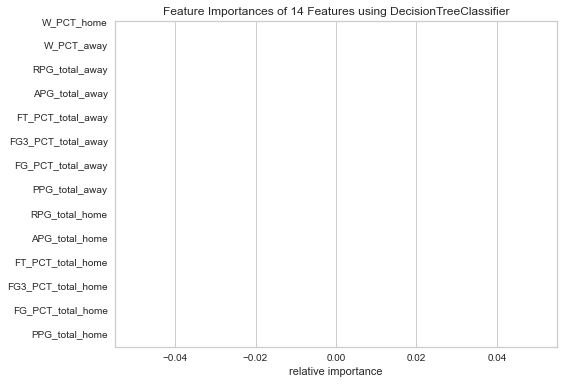

---------------------------------------------
i=13
FG3:

Best decision tree accuracy ({'min_impurity_decrease': 0.35, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2307
           1       0.00      0.00      0.00      2404

    accuracy                           0.49      4711
   macro avg       0.24      0.50      0.33      4711
weighted avg       0.24      0.49      0.32      4711



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

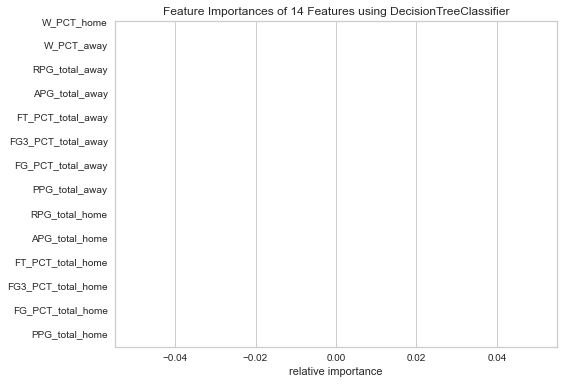

---------------------------------------------
i=14
FG3:

Best decision tree accuracy ({'min_impurity_decrease': 0.6, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2419
           1       0.49      1.00      0.65      2291

    accuracy                           0.49      4710
   macro avg       0.24      0.50      0.33      4710
weighted avg       0.24      0.49      0.32      4710



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

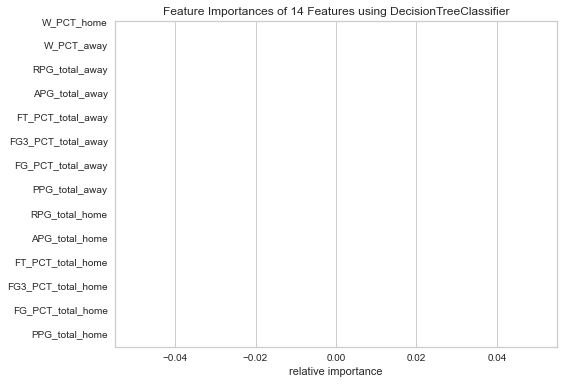

---------------------------------------------
Mean accuracy: 0.49066015707917643
Max accuracy: 0.4979834430057313
Min accuracy: 0.48482275525366164
i=15
FT:

Best decision tree accuracy ({'min_impurity_decrease': 0.35, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2337
           1       0.00      0.00      0.00      2345

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

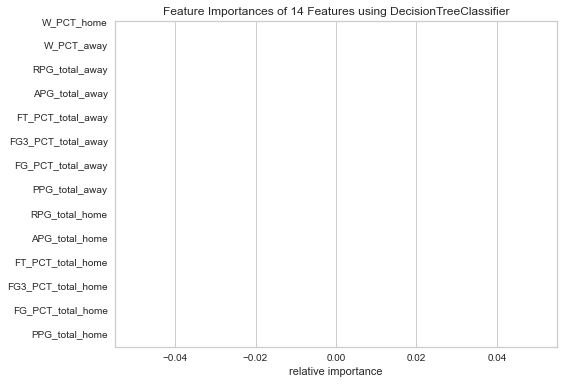

---------------------------------------------
i=16
FT:

Best decision tree accuracy ({'min_impurity_decrease': 0.6, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2322
           1       0.00      0.00      0.00      2360

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

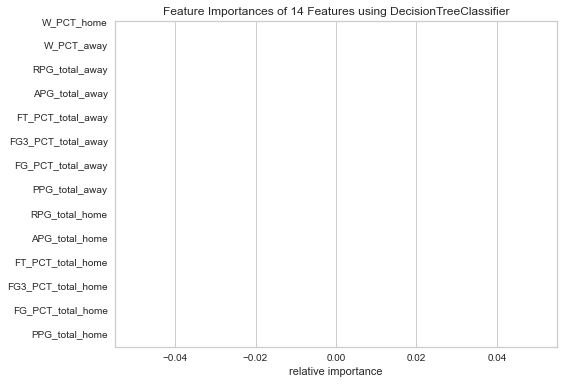

---------------------------------------------
i=17
FT:

Best decision tree accuracy ({'min_impurity_decrease': 0.15, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2360
           1       0.50      1.00      0.66      2322

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

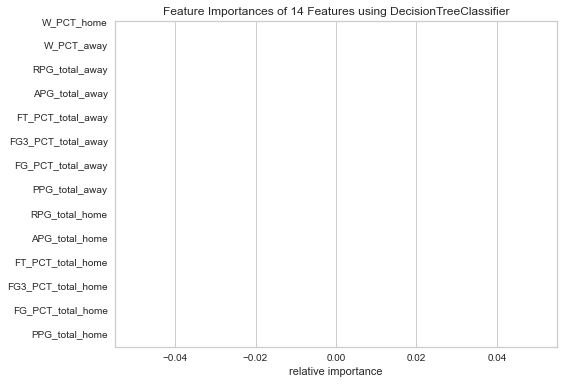

---------------------------------------------
i=18
FT:

Best decision tree accuracy ({'min_impurity_decrease': 0.7, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2343
           1       0.50      1.00      0.67      2339

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

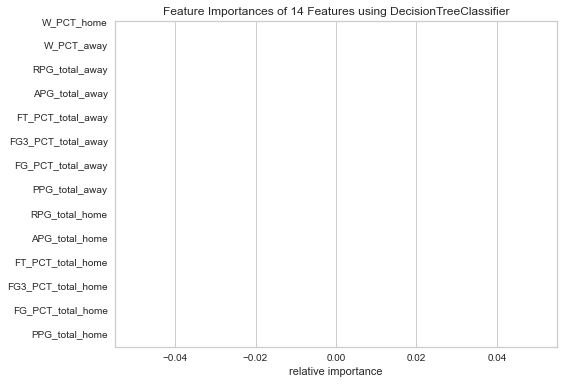

---------------------------------------------
i=19
FT:

Best decision tree accuracy ({'min_impurity_decrease': 0.35, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2343
           1       0.50      1.00      0.67      2339

    accuracy                           0.50      4682
   macro avg       0.25      0.50      0.33      4682
weighted avg       0.25      0.50      0.33      4682



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

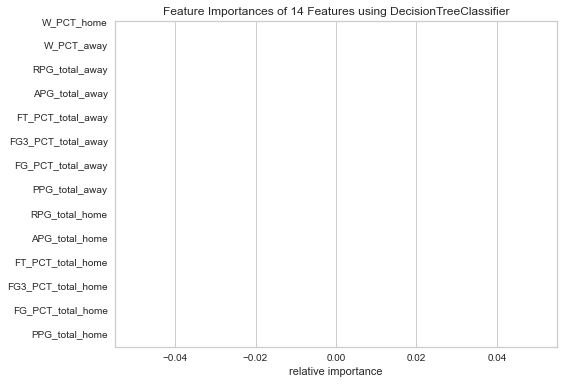

---------------------------------------------
Mean accuracy: 0.4976505766766339
Max accuracy: 0.49957283212302434
Min accuracy: 0.4959419051687313
i=20
AST:

Best decision tree accuracy ({'min_impurity_decrease': 0.8, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2556
           1       0.50      1.00      0.67      2540

    accuracy                           0.50      5096
   macro avg       0.25      0.50      0.33      5096
weighted avg       0.25      0.50      0.33      5096



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

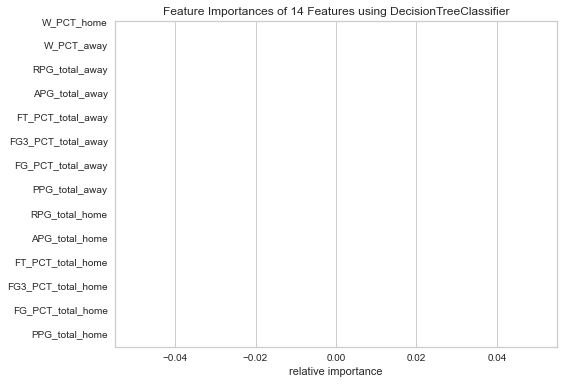

---------------------------------------------
i=21
AST:

Best decision tree accuracy ({'min_impurity_decrease': 0.75, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2578
           1       0.49      1.00      0.66      2517

    accuracy                           0.49      5095
   macro avg       0.25      0.50      0.33      5095
weighted avg       0.24      0.49      0.33      5095



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

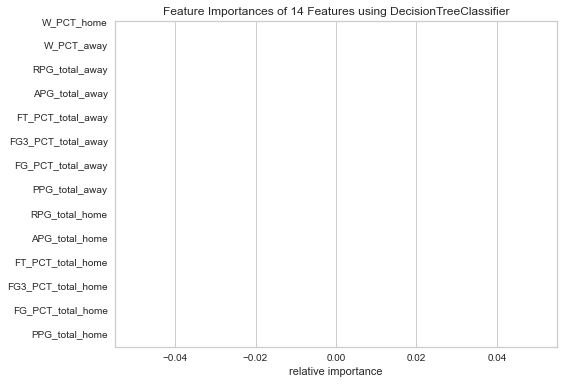

---------------------------------------------
i=22
AST:

Best decision tree accuracy ({'min_impurity_decrease': 0.95, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2522
           1       0.00      0.00      0.00      2573

    accuracy                           0.49      5095
   macro avg       0.25      0.50      0.33      5095
weighted avg       0.25      0.49      0.33      5095



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

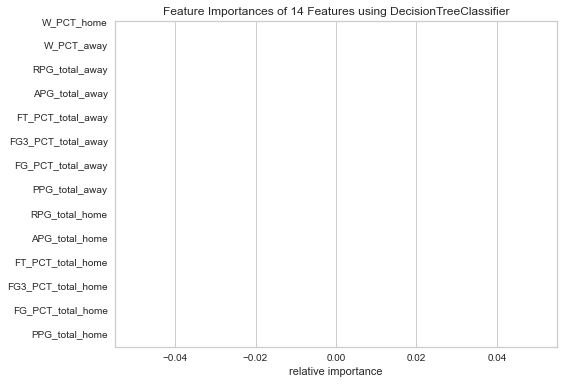

---------------------------------------------
i=23
AST:

Best decision tree accuracy ({'min_impurity_decrease': 0.2, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2531
           1       0.00      0.00      0.00      2564

    accuracy                           0.50      5095
   macro avg       0.25      0.50      0.33      5095
weighted avg       0.25      0.50      0.33      5095



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

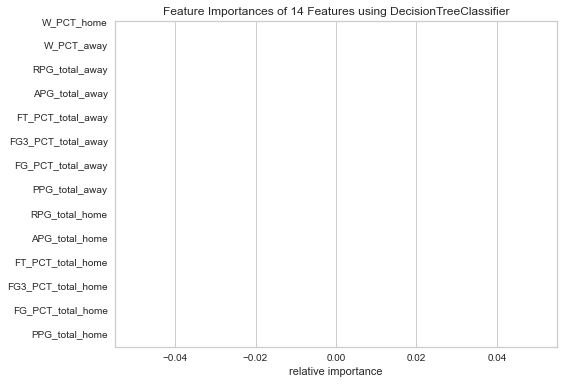

---------------------------------------------
i=24
AST:

Best decision tree accuracy ({'min_impurity_decrease': 0.55, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2551
           1       0.50      1.00      0.67      2544

    accuracy                           0.50      5095
   macro avg       0.25      0.50      0.33      5095
weighted avg       0.25      0.50      0.33      5095



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

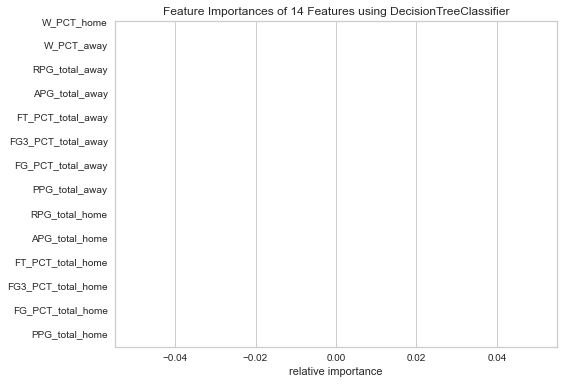

---------------------------------------------
Mean accuracy: 0.49605012609709087
Max accuracy: 0.49843014128728413
Min accuracy: 0.49401373895976447
i=25
REB:

Best decision tree accuracy ({'min_impurity_decrease': 0.35, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2470
           1       0.00      0.00      0.00      2475

    accuracy                           0.50      4945
   macro avg       0.25      0.50      0.33      4945
weighted avg       0.25      0.50      0.33      4945



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

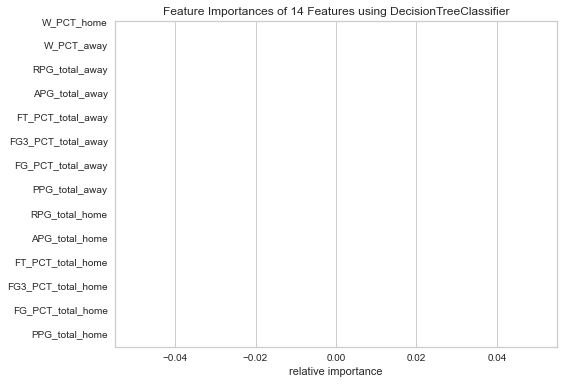

---------------------------------------------
i=26
REB:

Best decision tree accuracy ({'min_impurity_decrease': 0.25, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2413
           1       0.00      0.00      0.00      2532

    accuracy                           0.49      4945
   macro avg       0.24      0.50      0.33      4945
weighted avg       0.24      0.49      0.32      4945



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

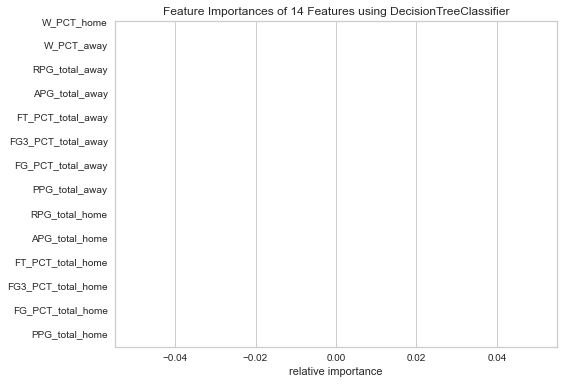

---------------------------------------------
i=27
REB:

Best decision tree accuracy ({'min_impurity_decrease': 0.05, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2479
           1       0.50      1.00      0.67      2465

    accuracy                           0.50      4944
   macro avg       0.25      0.50      0.33      4944
weighted avg       0.25      0.50      0.33      4944



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

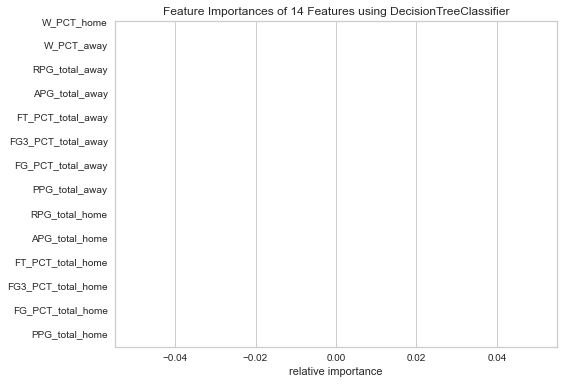

---------------------------------------------
i=28
REB:

Best decision tree accuracy ({'min_impurity_decrease': 0.75, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2473
           1       0.50      1.00      0.67      2471

    accuracy                           0.50      4944
   macro avg       0.25      0.50      0.33      4944
weighted avg       0.25      0.50      0.33      4944



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

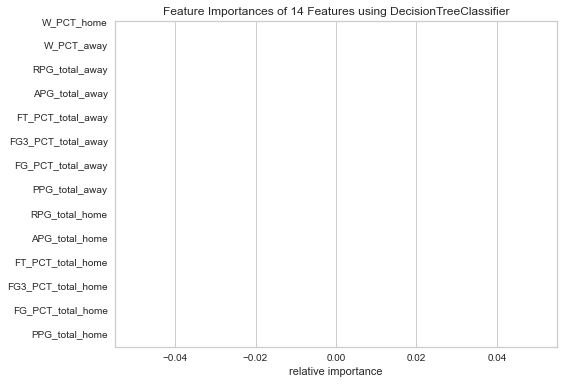

---------------------------------------------
i=29
REB:

Best decision tree accuracy ({'min_impurity_decrease': 0.05, 'criterion': 'gini'}): 0.49
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2526
           1       0.49      1.00      0.66      2418

    accuracy                           0.49      4944
   macro avg       0.24      0.50      0.33      4944
weighted avg       0.24      0.49      0.32      4944



c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

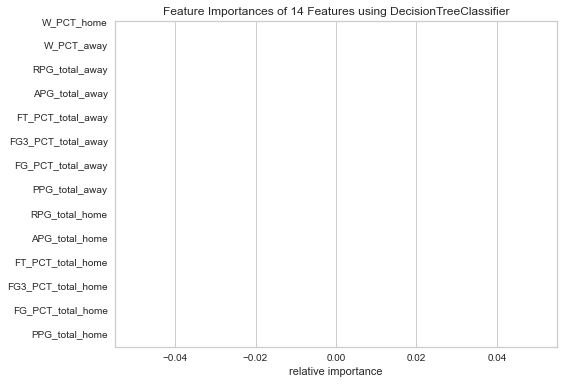

---------------------------------------------
Mean accuracy: 0.49646098998367155
Max accuracy: 0.4997977346278317
Min accuracy: 0.48796764408493426


In [29]:
# print_all_metrics_and_plot(
#     DecisionTreeClassifier(random_state=0),
#     X_train_dict,
#     X_test_dict,
#     {
#         'min_impurity_decrease': [0.0,0.01],
#         'criterion': ['gini', 'entropy'],
#     },
# )
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'min_impurity_decrease': [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95],
    'criterion': ['gini', 'entropy'],
})
# print('Any non-zero min_impurity_decrease causes all classifications to be 1')

## Try prune max leaves

i=0
WINNER:

Best decision tree accuracy ({'max_leaf_nodes': 1610, 'criterion': 'entropy'}): 0.54
              precision    recall  f1-score   support

           0       0.53      0.64      0.58      2695
           1       0.56      0.44      0.50      2789

    accuracy                           0.54      5484
   macro avg       0.54      0.54      0.54      5484
weighted avg       0.54      0.54      0.54      5484



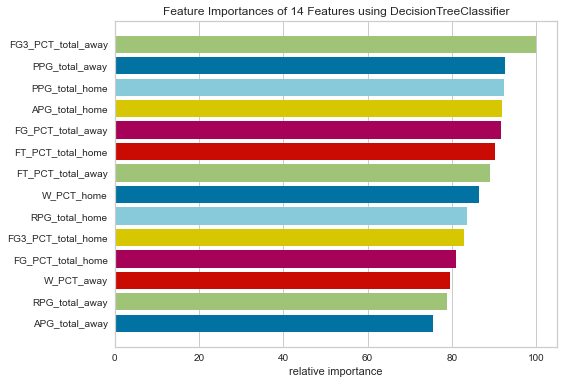

---------------------------------------------
i=1
WINNER:

Best decision tree accuracy ({'max_leaf_nodes': 1764, 'criterion': 'entropy'}): 0.54
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2780
           1       0.54      0.52      0.53      2704

    accuracy                           0.54      5484
   macro avg       0.54      0.54      0.54      5484
weighted avg       0.54      0.54      0.54      5484



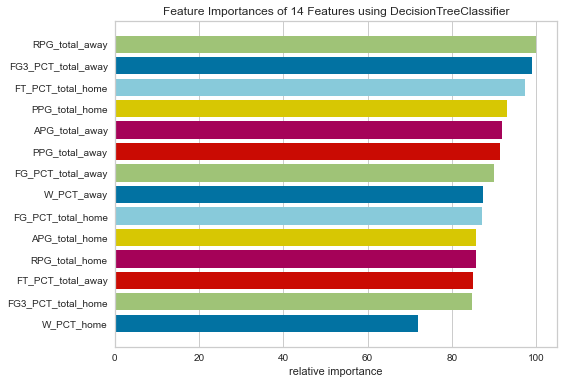

---------------------------------------------
i=2
WINNER:

Best decision tree accuracy ({'max_leaf_nodes': 1718, 'criterion': 'gini'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2727
           1       0.54      0.54      0.54      2757

    accuracy                           0.53      5484
   macro avg       0.53      0.53      0.53      5484
weighted avg       0.53      0.53      0.53      5484



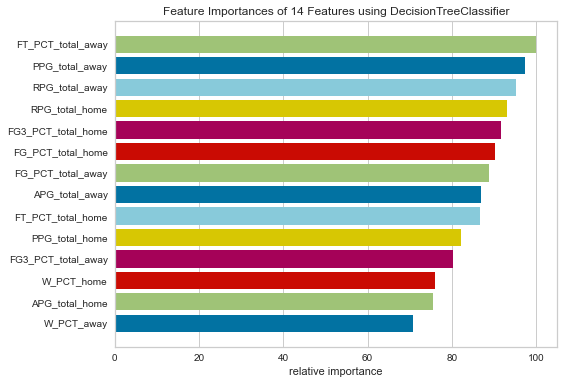

---------------------------------------------
i=3
WINNER:

Best decision tree accuracy ({'max_leaf_nodes': 1950, 'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2715
           1       0.54      0.54      0.54      2768

    accuracy                           0.54      5483
   macro avg       0.54      0.54      0.54      5483
weighted avg       0.54      0.54      0.54      5483



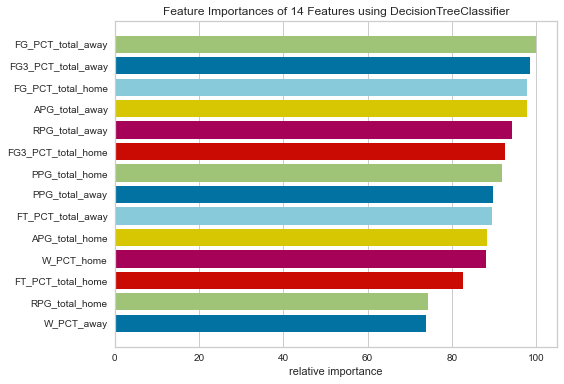

---------------------------------------------
i=4
WINNER:

Best decision tree accuracy ({'max_leaf_nodes': 1984, 'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.55      0.54      0.54      2792
           1       0.53      0.53      0.53      2691

    accuracy                           0.54      5483
   macro avg       0.54      0.54      0.54      5483
weighted avg       0.54      0.54      0.54      5483



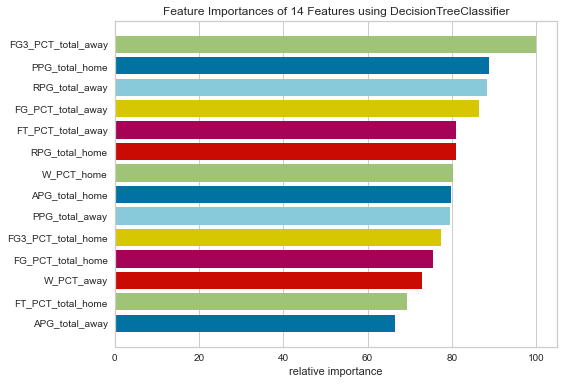

---------------------------------------------
Mean accuracy: 0.5389559141291171
Max accuracy: 0.5432166301969366
Min accuracy: 0.5344638949671773
i=5
FGP:

Best decision tree accuracy ({'max_leaf_nodes': 1978, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2614
           1       0.51      0.51      0.51      2495

    accuracy                           0.52      5109
   macro avg       0.52      0.52      0.52      5109
weighted avg       0.52      0.52      0.52      5109



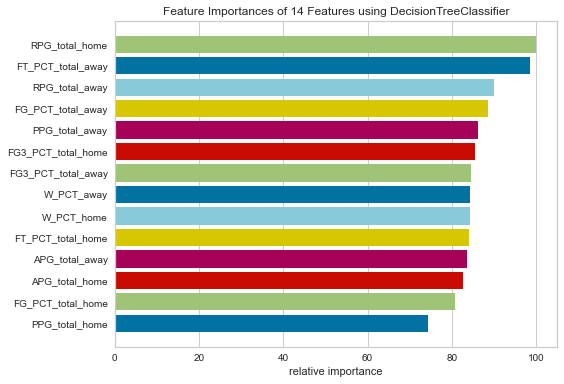

---------------------------------------------
i=6
FGP:

Best decision tree accuracy ({'max_leaf_nodes': 1852, 'criterion': 'entropy'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.56      0.54      2571
           1       0.52      0.48      0.50      2538

    accuracy                           0.52      5109
   macro avg       0.52      0.52      0.52      5109
weighted avg       0.52      0.52      0.52      5109



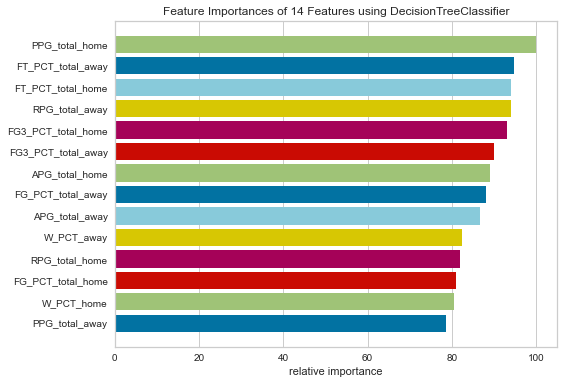

---------------------------------------------
i=7
FGP:

Best decision tree accuracy ({'max_leaf_nodes': 1928, 'criterion': 'entropy'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2559
           1       0.53      0.52      0.53      2549

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



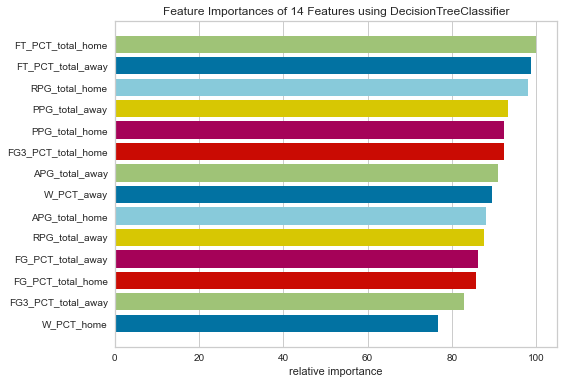

---------------------------------------------
i=8
FGP:

Best decision tree accuracy ({'max_leaf_nodes': 1476, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.53      0.51      2470
           1       0.53      0.50      0.52      2638

    accuracy                           0.51      5108
   macro avg       0.51      0.51      0.51      5108
weighted avg       0.52      0.51      0.51      5108



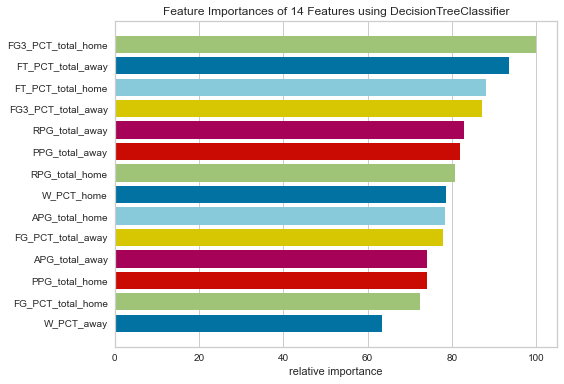

---------------------------------------------
i=9
FGP:

Best decision tree accuracy ({'max_leaf_nodes': 1880, 'criterion': 'entropy'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.58      0.55      2557
           1       0.54      0.49      0.51      2551

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



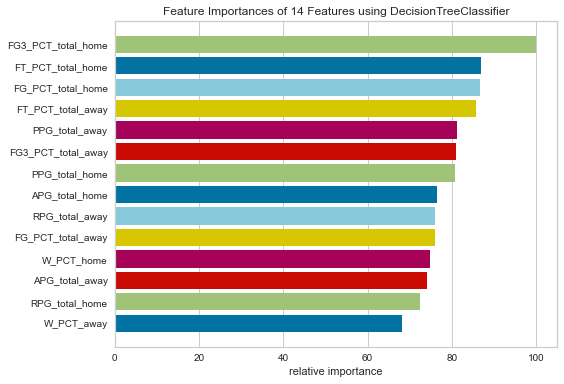

---------------------------------------------
Mean accuracy: 0.5221201974711662
Max accuracy: 0.5338684416601409
Min accuracy: 0.514487079091621
i=10
FG3:

Best decision tree accuracy ({'max_leaf_nodes': 566, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.62      0.56      2365
           1       0.51      0.40      0.45      2346

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



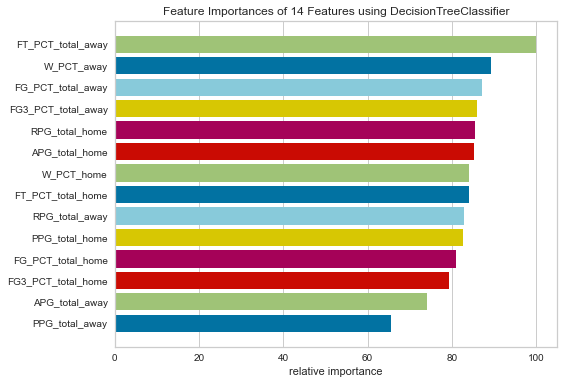

---------------------------------------------
i=11
FG3:

Best decision tree accuracy ({'max_leaf_nodes': 1898, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2402
           1       0.50      0.52      0.51      2309

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



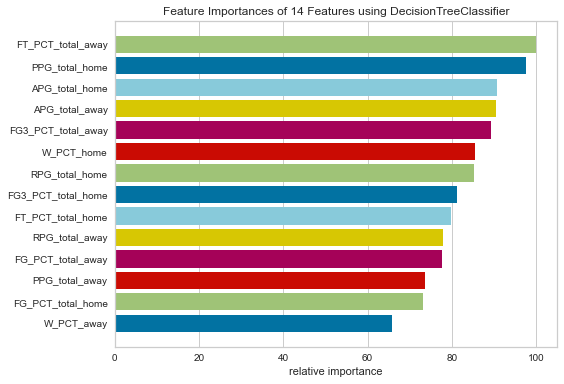

---------------------------------------------
i=12
FG3:

Best decision tree accuracy ({'max_leaf_nodes': 562, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.48      0.52      0.50      2284
           1       0.51      0.47      0.49      2427

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



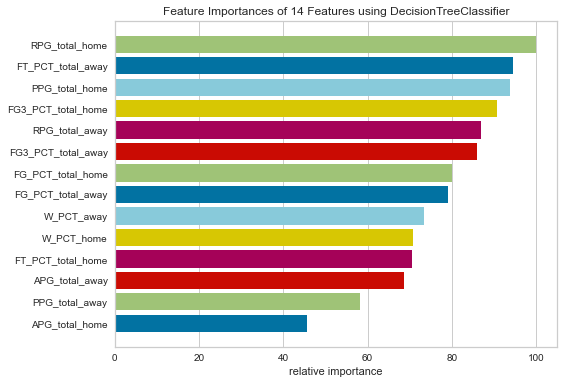

---------------------------------------------
i=13
FG3:

Best decision tree accuracy ({'max_leaf_nodes': 1560, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2307
           1       0.52      0.51      0.52      2404

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



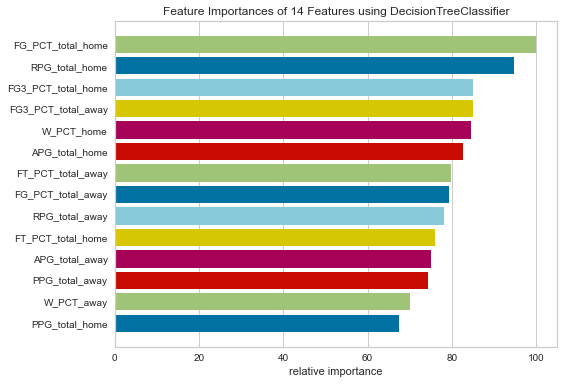

---------------------------------------------
i=14
FG3:

Best decision tree accuracy ({'max_leaf_nodes': 1838, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.48      0.50      2419
           1       0.49      0.53      0.51      2291

    accuracy                           0.51      4710
   macro avg       0.51      0.51      0.51      4710
weighted avg       0.51      0.51      0.51      4710



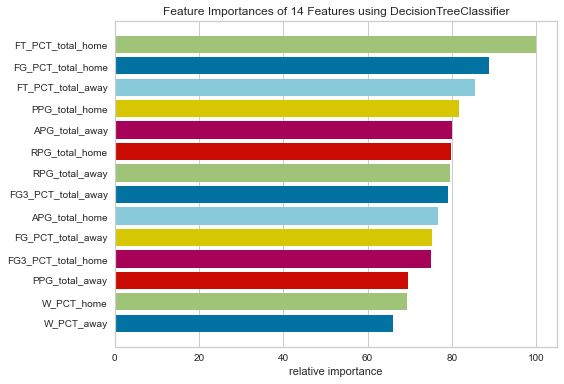

---------------------------------------------
Mean accuracy: 0.5081723625557206
Max accuracy: 0.512630014858841
Min accuracy: 0.4981957121630227
i=15
FT:

Best decision tree accuracy ({'max_leaf_nodes': 478, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2337
           1       0.50      0.50      0.50      2345

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



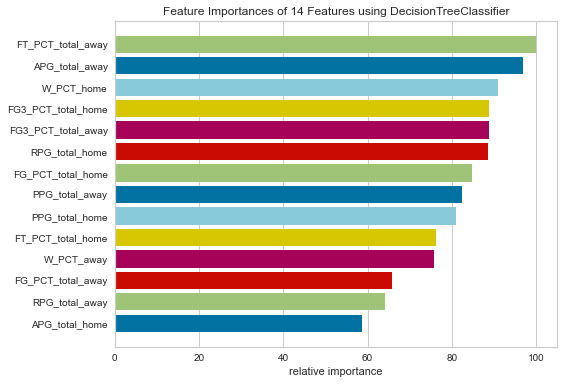

---------------------------------------------
i=16
FT:

Best decision tree accuracy ({'max_leaf_nodes': 92, 'criterion': 'entropy'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.34      0.41      2322
           1       0.50      0.65      0.57      2360

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.49      4682
weighted avg       0.50      0.50      0.49      4682



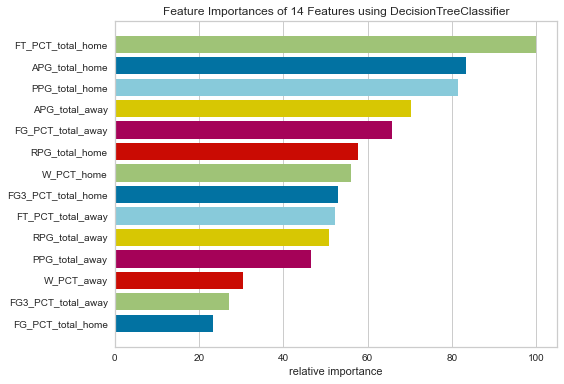

---------------------------------------------
i=17
FT:

Best decision tree accuracy ({'max_leaf_nodes': 1048, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.45      0.48      2360
           1       0.50      0.55      0.52      2322

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



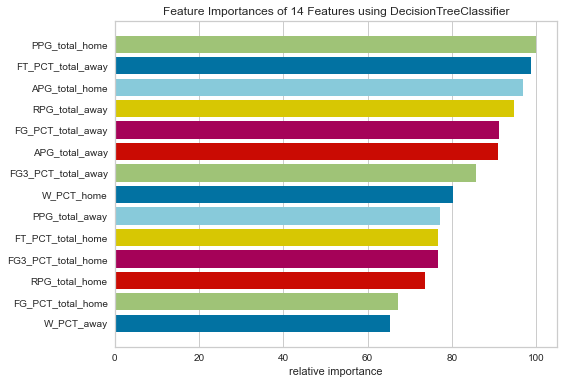

---------------------------------------------
i=18
FT:

Best decision tree accuracy ({'max_leaf_nodes': 920, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.44      0.47      2343
           1       0.50      0.57      0.53      2339

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



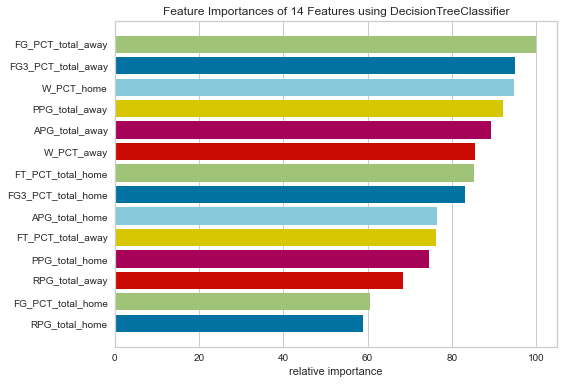

---------------------------------------------
i=19
FT:

Best decision tree accuracy ({'max_leaf_nodes': 200, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.57      0.54      2343
           1       0.50      0.43      0.46      2339

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



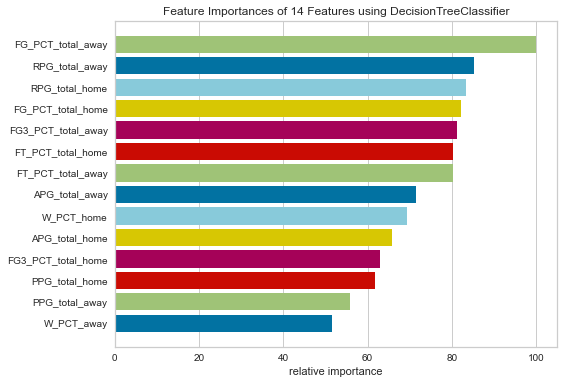

---------------------------------------------
Mean accuracy: 0.501174711661683
Max accuracy: 0.5038445108927808
Min accuracy: 0.49957283212302434
i=20
AST:

Best decision tree accuracy ({'max_leaf_nodes': 1892, 'criterion': 'entropy'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2556
           1       0.53      0.50      0.51      2540

    accuracy                           0.53      5096
   macro avg       0.53      0.53      0.53      5096
weighted avg       0.53      0.53      0.53      5096



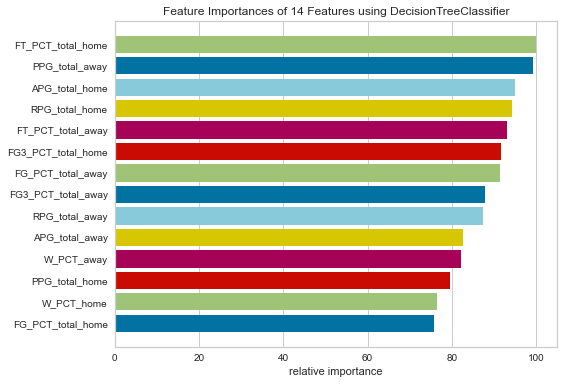

---------------------------------------------
i=21
AST:

Best decision tree accuracy ({'max_leaf_nodes': 1930, 'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.55      0.55      2578
           1       0.53      0.52      0.53      2517

    accuracy                           0.54      5095
   macro avg       0.54      0.54      0.54      5095
weighted avg       0.54      0.54      0.54      5095



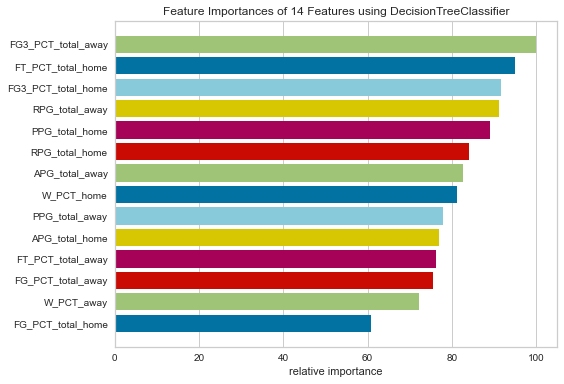

---------------------------------------------
i=22
AST:

Best decision tree accuracy ({'max_leaf_nodes': 1938, 'criterion': 'entropy'}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.62      0.56      2522
           1       0.53      0.43      0.47      2573

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



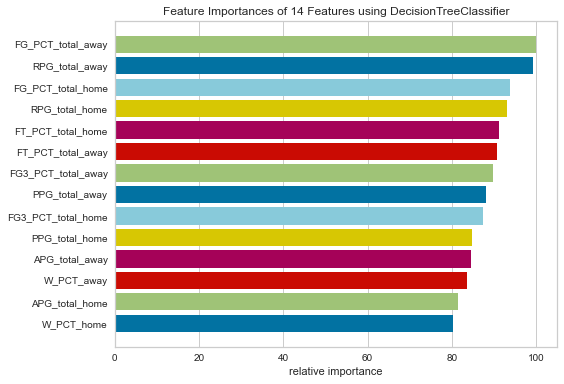

---------------------------------------------
i=23
AST:

Best decision tree accuracy ({'max_leaf_nodes': 1556, 'criterion': 'entropy'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2531
           1       0.54      0.52      0.53      2564

    accuracy                           0.53      5095
   macro avg       0.53      0.53      0.53      5095
weighted avg       0.53      0.53      0.53      5095



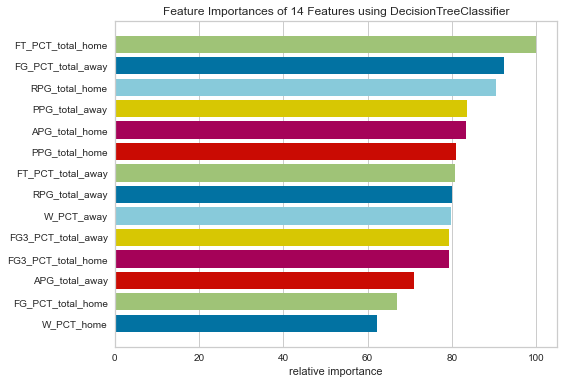

---------------------------------------------
i=24
AST:

Best decision tree accuracy ({'max_leaf_nodes': 1430, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2551
           1       0.52      0.52      0.52      2544

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



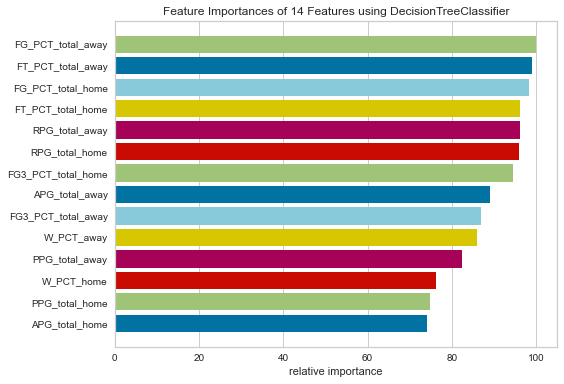

---------------------------------------------
Mean accuracy: 0.5295620456229596
Max accuracy: 0.5371933267909715
Min accuracy: 0.5207065750736015
i=25
REB:

Best decision tree accuracy ({'max_leaf_nodes': 1872, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.53      0.52      2470
           1       0.52      0.52      0.52      2475

    accuracy                           0.52      4945
   macro avg       0.52      0.52      0.52      4945
weighted avg       0.52      0.52      0.52      4945



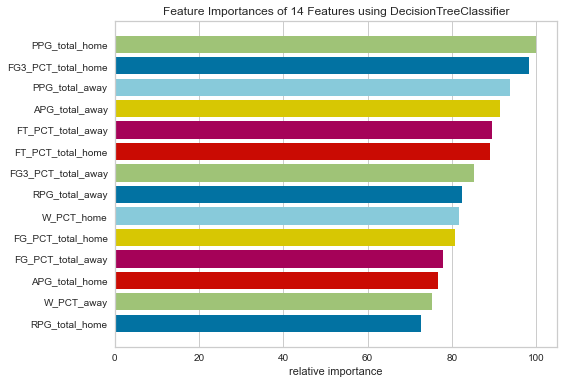

---------------------------------------------
i=26
REB:

Best decision tree accuracy ({'max_leaf_nodes': 1858, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.49      0.48      0.49      2413
           1       0.52      0.53      0.52      2532

    accuracy                           0.51      4945
   macro avg       0.51      0.51      0.51      4945
weighted avg       0.51      0.51      0.51      4945



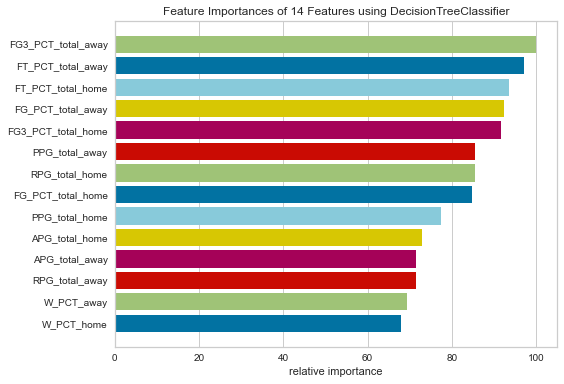

---------------------------------------------
i=27
REB:

Best decision tree accuracy ({'max_leaf_nodes': 1424, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      2479
           1       0.51      0.53      0.52      2465

    accuracy                           0.51      4944
   macro avg       0.51      0.51      0.51      4944
weighted avg       0.51      0.51      0.51      4944



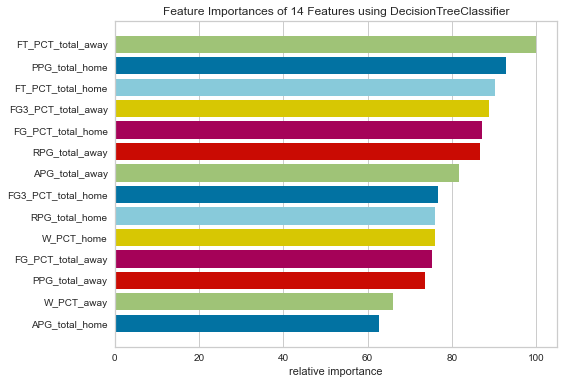

---------------------------------------------
i=28
REB:

Best decision tree accuracy ({'max_leaf_nodes': 1742, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2473
           1       0.51      0.51      0.51      2471

    accuracy                           0.51      4944
   macro avg       0.51      0.51      0.51      4944
weighted avg       0.51      0.51      0.51      4944



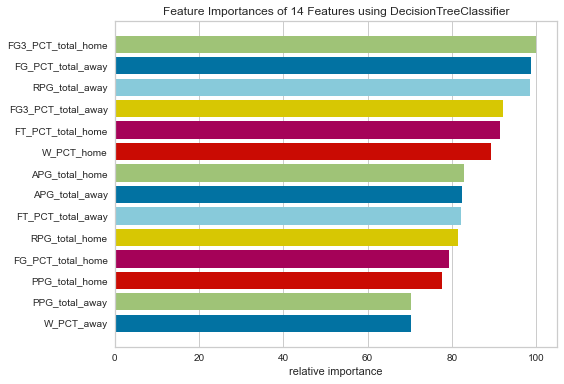

---------------------------------------------
i=29
REB:

Best decision tree accuracy ({'max_leaf_nodes': 1344, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.53      0.48      0.50      2526
           1       0.50      0.55      0.53      2418

    accuracy                           0.51      4944
   macro avg       0.51      0.51      0.51      4944
weighted avg       0.52      0.51      0.51      4944



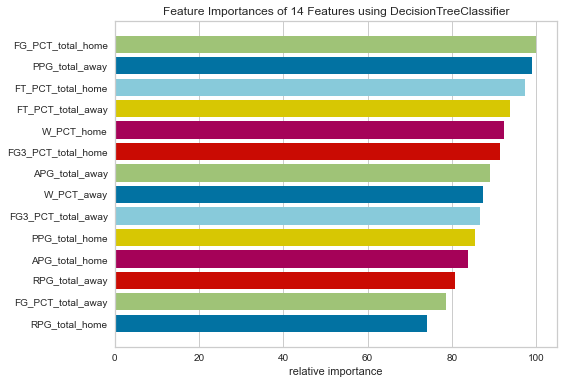

---------------------------------------------
Mean accuracy: 0.5139041900222839
Max accuracy: 0.5235591506572296
Min accuracy: 0.5071789686552073


In [30]:
# print_all_metrics_and_plot(
#     DecisionTreeClassifier(random_state=0),
#     X_train_dict,
#     X_test_dict,
#     {
#         'max_leaf_nodes': [*range(4,60)],
#         'criterion': ['gini', 'entropy'],
#     },
# )
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'max_leaf_nodes': [*range(4,2000,2)],
    'criterion': ['gini', 'entropy'],
})

## Try prune max features

i=0
WINNER:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'entropy'}): 0.55
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      2695
           1       0.56      0.54      0.55      2789

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



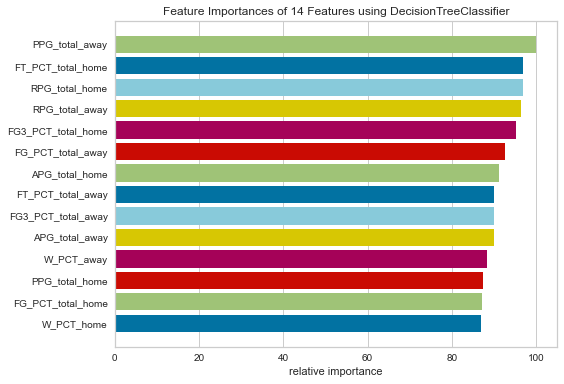

---------------------------------------------
i=1
WINNER:

Best decision tree accuracy ({'max_features': 2, 'criterion': 'entropy'}): 0.55
              precision    recall  f1-score   support

           0       0.55      0.56      0.56      2780
           1       0.54      0.54      0.54      2704

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



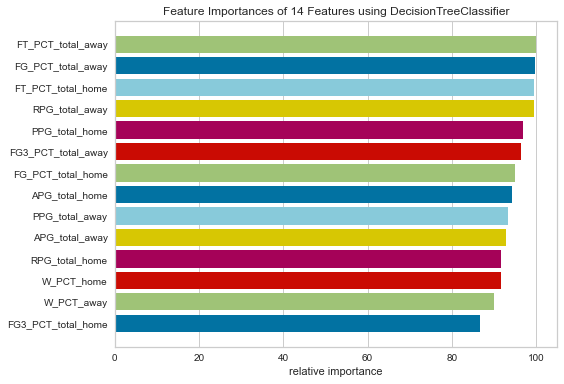

---------------------------------------------
i=2
WINNER:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2727
           1       0.54      0.52      0.53      2757

    accuracy                           0.54      5484
   macro avg       0.54      0.54      0.54      5484
weighted avg       0.54      0.54      0.54      5484



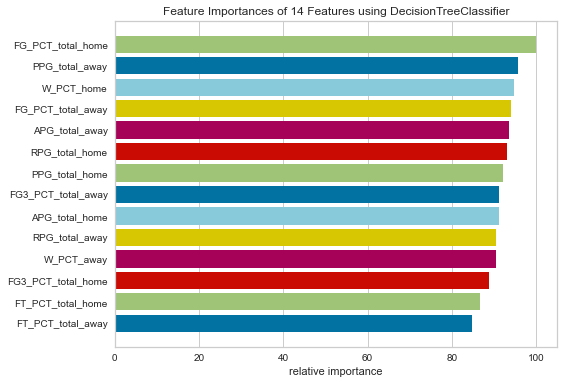

---------------------------------------------
i=3
WINNER:

Best decision tree accuracy ({'max_features': 2, 'criterion': 'entropy'}): 0.56
              precision    recall  f1-score   support

           0       0.55      0.58      0.57      2715
           1       0.57      0.54      0.55      2768

    accuracy                           0.56      5483
   macro avg       0.56      0.56      0.56      5483
weighted avg       0.56      0.56      0.56      5483



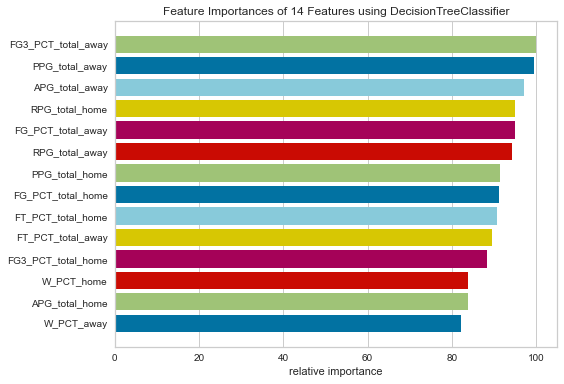

---------------------------------------------
i=4
WINNER:

Best decision tree accuracy ({'max_features': 4, 'criterion': 'gini'}): 0.54
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      2792
           1       0.53      0.53      0.53      2691

    accuracy                           0.54      5483
   macro avg       0.54      0.54      0.54      5483
weighted avg       0.54      0.54      0.54      5483



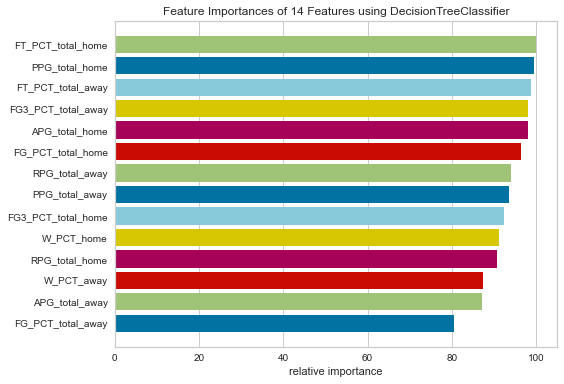

---------------------------------------------
Mean accuracy: 0.547618514317778
Max accuracy: 0.5597300747765822
Min accuracy: 0.5353756382202771
i=5
FGP:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.53
              precision    recall  f1-score   support

           0       0.54      0.53      0.54      2614
           1       0.52      0.52      0.52      2495

    accuracy                           0.53      5109
   macro avg       0.53      0.53      0.53      5109
weighted avg       0.53      0.53      0.53      5109



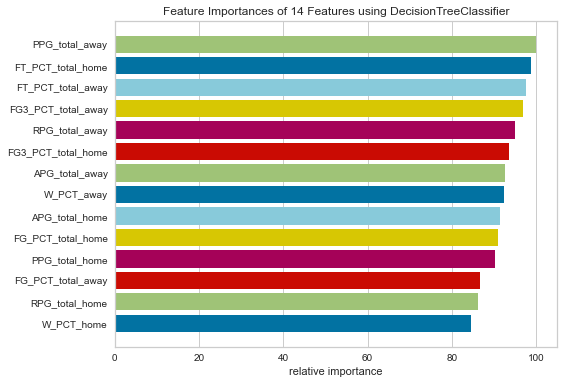

---------------------------------------------
i=6
FGP:

Best decision tree accuracy ({'max_features': 4, 'criterion': 'entropy'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.54      0.53      2571
           1       0.52      0.51      0.52      2538

    accuracy                           0.53      5109
   macro avg       0.53      0.53      0.53      5109
weighted avg       0.53      0.53      0.53      5109



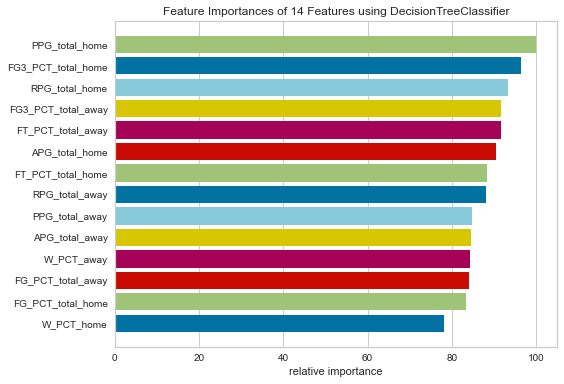

---------------------------------------------
i=7
FGP:

Best decision tree accuracy ({'max_features': 'sqrt', 'criterion': 'entropy'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.53      0.52      2559
           1       0.52      0.52      0.52      2549

    accuracy                           0.52      5108
   macro avg       0.52      0.52      0.52      5108
weighted avg       0.52      0.52      0.52      5108



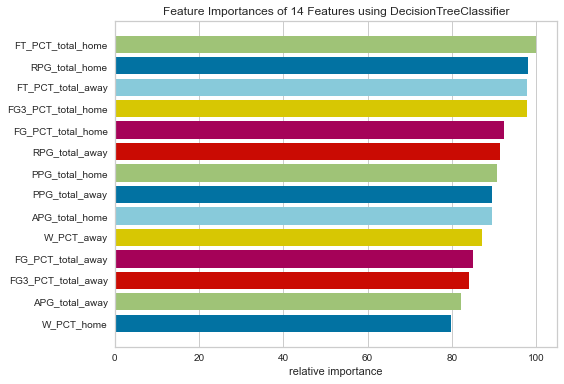

---------------------------------------------
i=8
FGP:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'entropy'}): 0.53
              precision    recall  f1-score   support

           0       0.52      0.55      0.53      2470
           1       0.55      0.51      0.53      2638

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



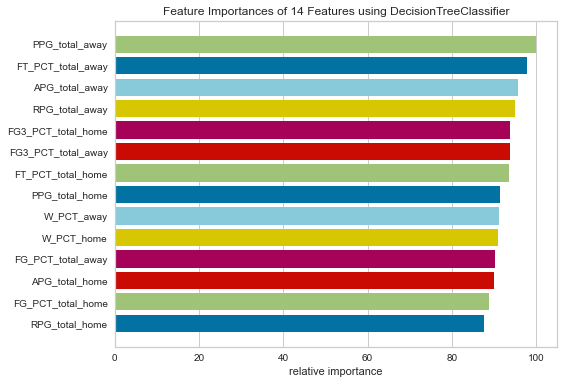

---------------------------------------------
i=9
FGP:

Best decision tree accuracy ({'max_features': 2, 'criterion': 'gini'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.54      0.53      2557
           1       0.53      0.51      0.52      2551

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



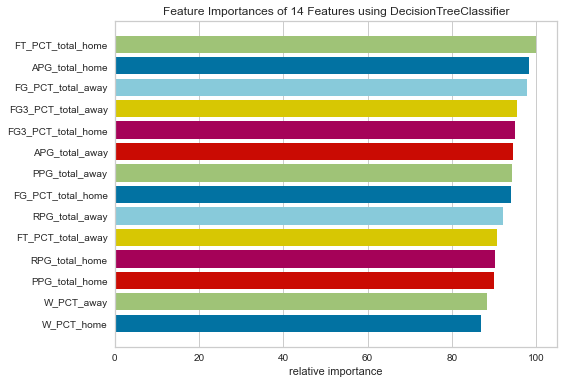

---------------------------------------------
Mean accuracy: 0.5270627053031693
Max accuracy: 0.5323022709475332
Min accuracy: 0.5211433046202036
i=10
FG3:

Best decision tree accuracy ({'max_features': 5, 'criterion': 'entropy'}): 0.49
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      2365
           1       0.49      0.51      0.50      2346

    accuracy                           0.49      4711
   macro avg       0.49      0.49      0.49      4711
weighted avg       0.49      0.49      0.49      4711



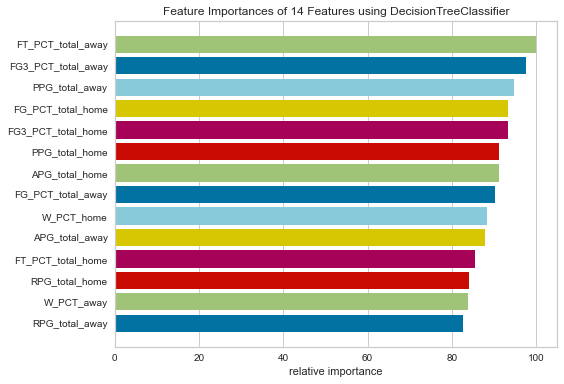

---------------------------------------------
i=11
FG3:

Best decision tree accuracy ({'max_features': 9, 'criterion': 'entropy'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.52      0.53      2402
           1       0.51      0.53      0.52      2309

    accuracy                           0.52      4711
   macro avg       0.52      0.52      0.52      4711
weighted avg       0.52      0.52      0.52      4711



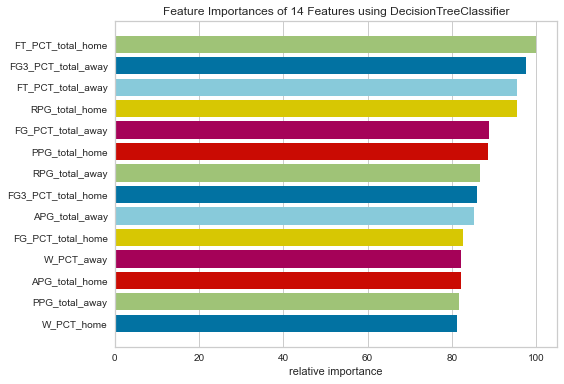

---------------------------------------------
i=12
FG3:

Best decision tree accuracy ({'max_features': 7, 'criterion': 'entropy'}): 0.51
              precision    recall  f1-score   support

           0       0.49      0.53      0.51      2284
           1       0.53      0.49      0.51      2427

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



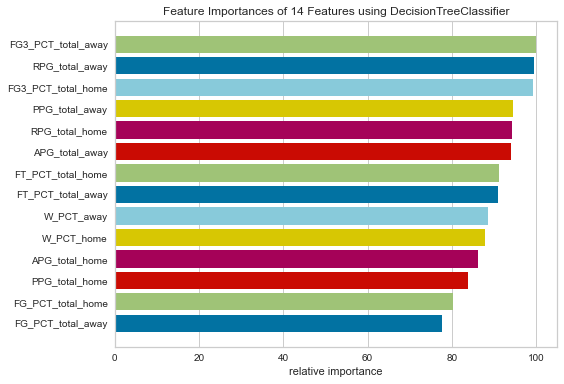

---------------------------------------------
i=13
FG3:

Best decision tree accuracy ({'max_features': 4, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.53      0.52      2307
           1       0.52      0.49      0.51      2404

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



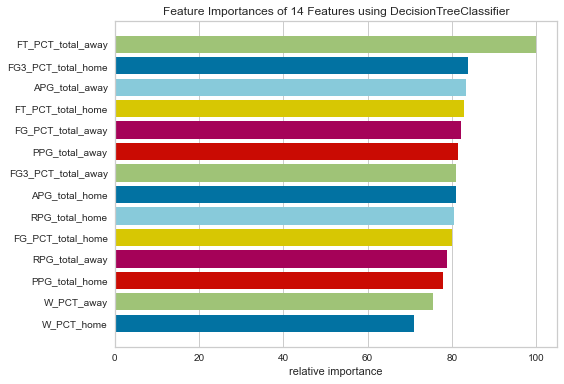

---------------------------------------------
i=14
FG3:

Best decision tree accuracy ({'max_features': None, 'criterion': 'gini'}): 0.50
              precision    recall  f1-score   support

           0       0.52      0.48      0.50      2419
           1       0.49      0.52      0.50      2291

    accuracy                           0.50      4710
   macro avg       0.50      0.50      0.50      4710
weighted avg       0.50      0.50      0.50      4710



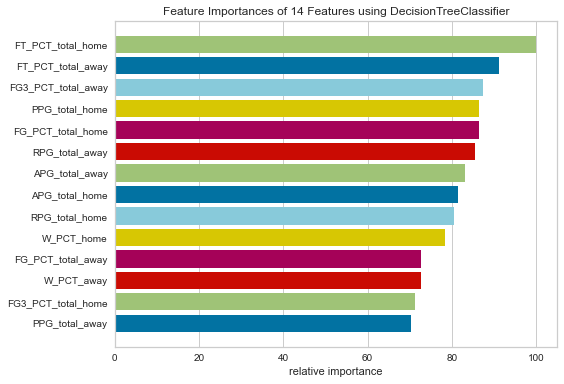

---------------------------------------------
Mean accuracy: 0.5093398429208236
Max accuracy: 0.522606665251539
Min accuracy: 0.49458713648906816
i=15
FT:

Best decision tree accuracy ({'max_features': 8, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      2337
           1       0.51      0.52      0.51      2345

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



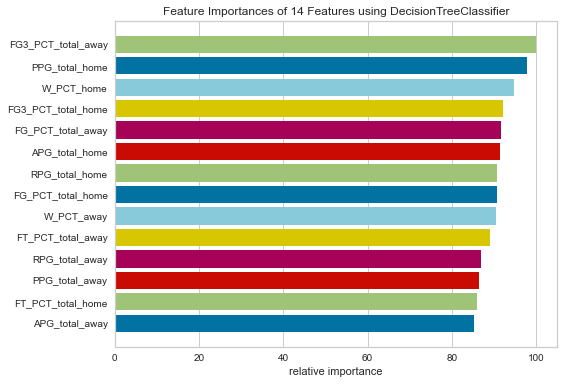

---------------------------------------------
i=16
FT:

Best decision tree accuracy ({'max_features': 8, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2322
           1       0.51      0.51      0.51      2360

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



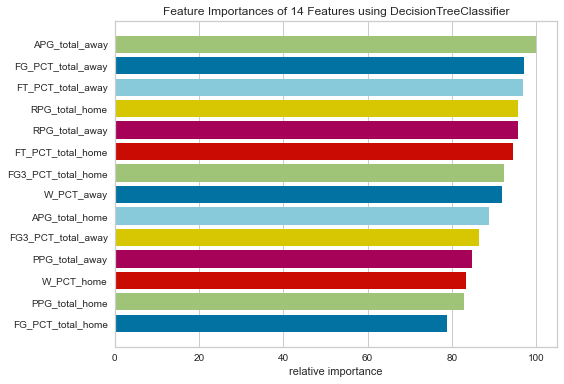

---------------------------------------------
i=17
FT:

Best decision tree accuracy ({'max_features': None, 'criterion': 'gini'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2360
           1       0.51      0.51      0.51      2322

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



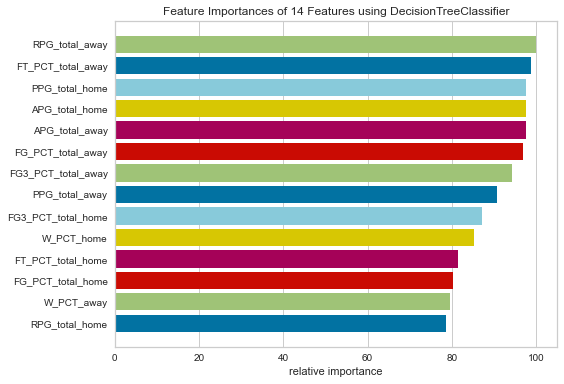

---------------------------------------------
i=18
FT:

Best decision tree accuracy ({'max_features': 7, 'criterion': 'entropy'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2343
           1       0.52      0.51      0.52      2339

    accuracy                           0.52      4682
   macro avg       0.52      0.52      0.52      4682
weighted avg       0.52      0.52      0.52      4682



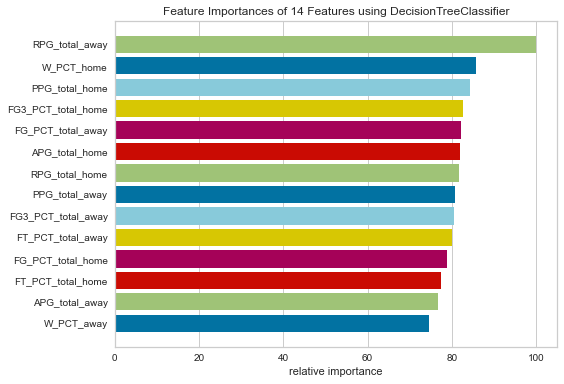

---------------------------------------------
i=19
FT:

Best decision tree accuracy ({'max_features': 2, 'criterion': 'entropy'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2343
           1       0.52      0.53      0.53      2339

    accuracy                           0.52      4682
   macro avg       0.52      0.52      0.52      4682
weighted avg       0.52      0.52      0.52      4682



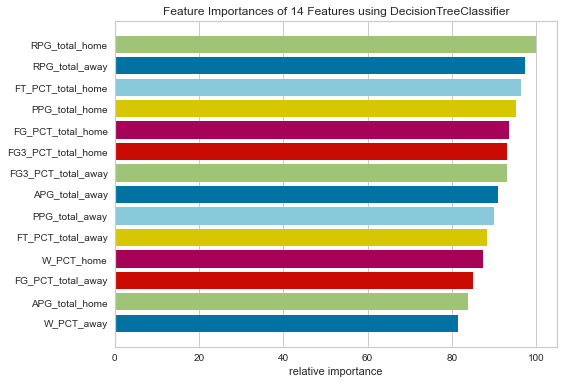

---------------------------------------------
Mean accuracy: 0.510999572832123
Max accuracy: 0.5177274668944896
Min accuracy: 0.5053395984621957
i=20
AST:

Best decision tree accuracy ({'max_features': 5, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2556
           1       0.52      0.52      0.52      2540

    accuracy                           0.52      5096
   macro avg       0.52      0.52      0.52      5096
weighted avg       0.52      0.52      0.52      5096



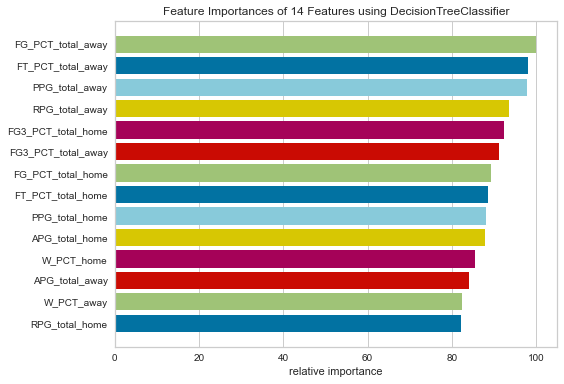

---------------------------------------------
i=21
AST:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      2578
           1       0.52      0.53      0.52      2517

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



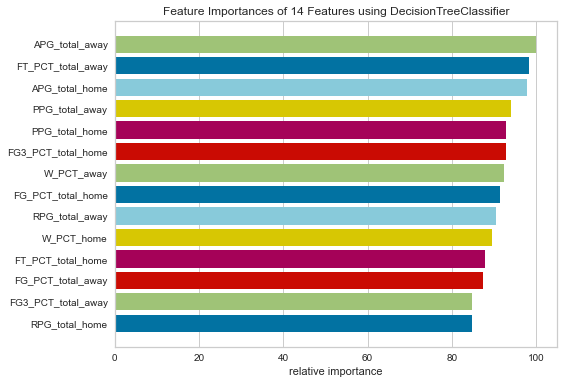

---------------------------------------------
i=22
AST:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.53      0.52      2522
           1       0.53      0.51      0.52      2573

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



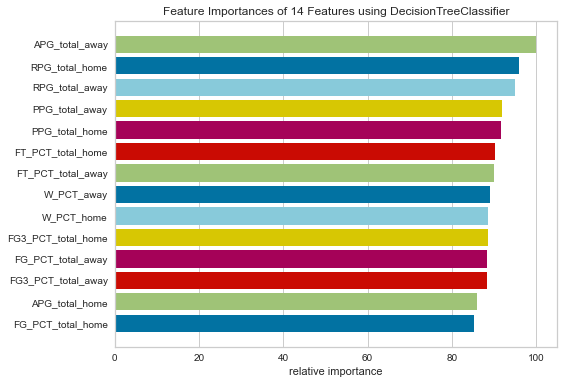

---------------------------------------------
i=23
AST:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'entropy'}): 0.52
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      2531
           1       0.52      0.51      0.51      2564

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



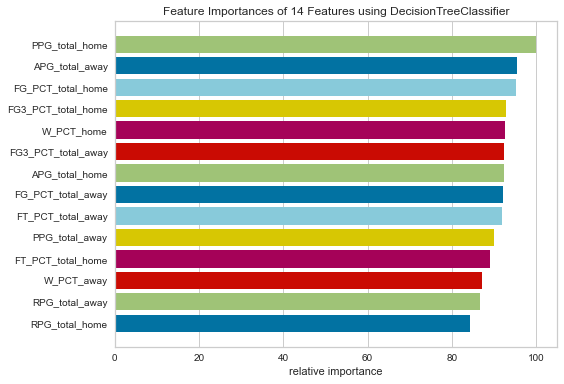

---------------------------------------------
i=24
AST:

Best decision tree accuracy ({'max_features': 'log2', 'criterion': 'gini'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2551
           1       0.53      0.51      0.52      2544

    accuracy                           0.53      5095
   macro avg       0.53      0.53      0.53      5095
weighted avg       0.53      0.53      0.53      5095



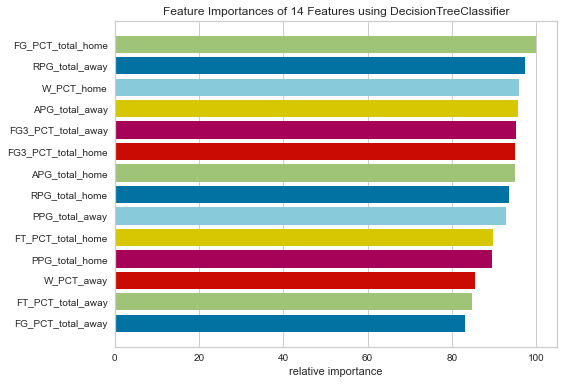

---------------------------------------------
Mean accuracy: 0.5218584916415423
Max accuracy: 0.5239403453689168
Min accuracy: 0.5179587831207065
i=25
REB:

Best decision tree accuracy ({'max_features': 'log2', 'criterion': 'gini'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      2470
           1       0.53      0.53      0.53      2475

    accuracy                           0.53      4945
   macro avg       0.53      0.53      0.53      4945
weighted avg       0.53      0.53      0.53      4945



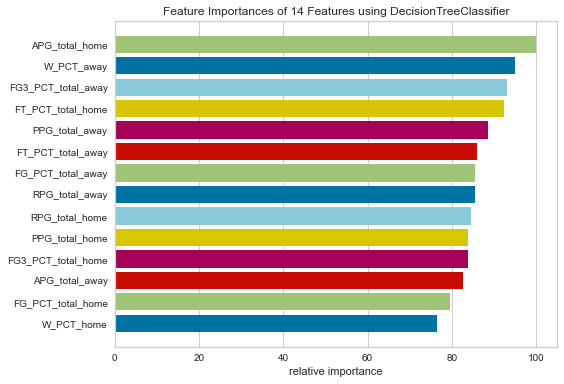

---------------------------------------------
i=26
REB:

Best decision tree accuracy ({'max_features': 'log2', 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2413
           1       0.53      0.51      0.52      2532

    accuracy                           0.52      4945
   macro avg       0.52      0.52      0.52      4945
weighted avg       0.52      0.52      0.52      4945



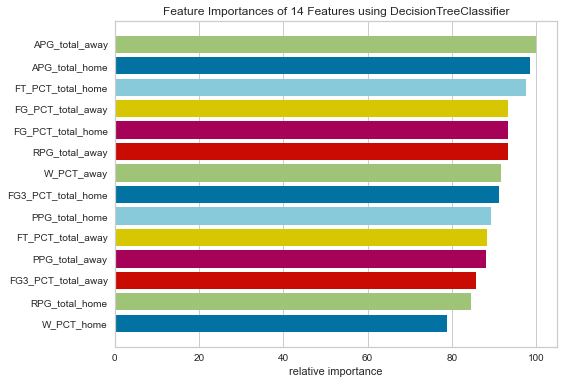

---------------------------------------------
i=27
REB:

Best decision tree accuracy ({'max_features': 4, 'criterion': 'gini'}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2479
           1       0.52      0.53      0.52      2465

    accuracy                           0.52      4944
   macro avg       0.52      0.52      0.52      4944
weighted avg       0.52      0.52      0.52      4944



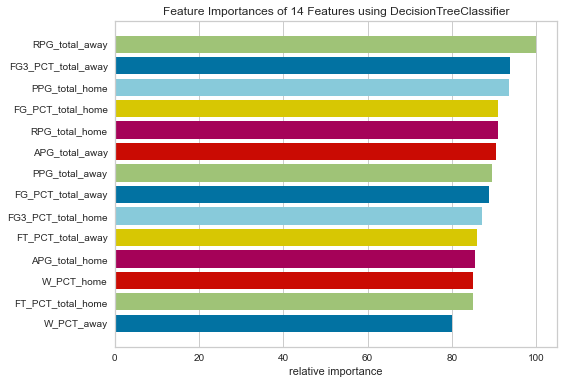

---------------------------------------------
i=28
REB:

Best decision tree accuracy ({'max_features': 3, 'criterion': 'gini'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2473
           1       0.53      0.54      0.54      2471

    accuracy                           0.53      4944
   macro avg       0.53      0.53      0.53      4944
weighted avg       0.53      0.53      0.53      4944



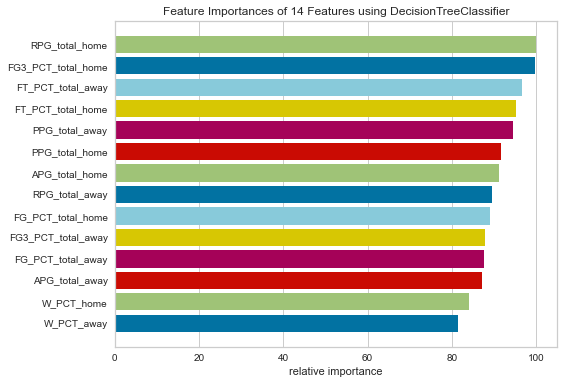

---------------------------------------------
i=29
REB:

Best decision tree accuracy ({'max_features': 1, 'criterion': 'entropy'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      2526
           1       0.51      0.51      0.51      2418

    accuracy                           0.52      4944
   macro avg       0.52      0.52      0.52      4944
weighted avg       0.52      0.52      0.52      4944



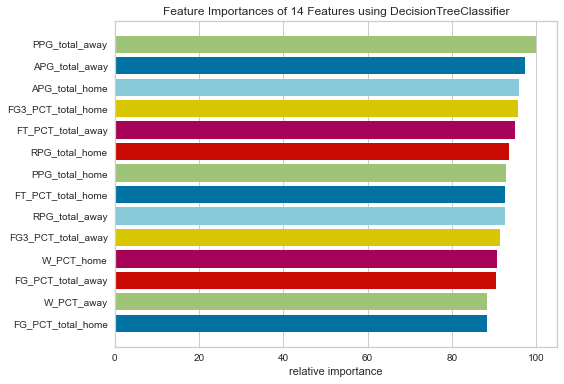

---------------------------------------------
Mean accuracy: 0.5244719830759716
Max accuracy: 0.5337783171521036
Min accuracy: 0.5158746208291203


In [31]:
# print_all_metrics_and_plot(
#     DecisionTreeClassifier(random_state=0),
#     X_train_dict,
#     X_test_dict,
#     {
#         'max_features': [*range(1,len(cumulative_stats_df.columns)//2+1), 'sqrt', 'log2', None],
#         'criterion': ['gini', 'entropy'],
#     },
# )
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'max_features': [*range(1,len(cumulative_stats_df.columns)//2+1), 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
})

## Try class weight balance

i=0


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.56
              precision    recall  f1-score   support

           0       0.55      0.56      0.56      2695
           1       0.57      0.56      0.56      2789

    accuracy                           0.56      5484
   macro avg       0.56      0.56      0.56      5484
weighted avg       0.56      0.56      0.56      5484



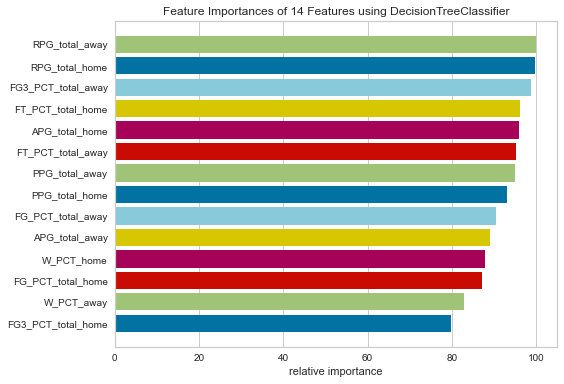

---------------------------------------------
i=1


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.55
              precision    recall  f1-score   support

           0       0.56      0.56      0.56      2780
           1       0.54      0.54      0.54      2704

    accuracy                           0.55      5484
   macro avg       0.55      0.55      0.55      5484
weighted avg       0.55      0.55      0.55      5484



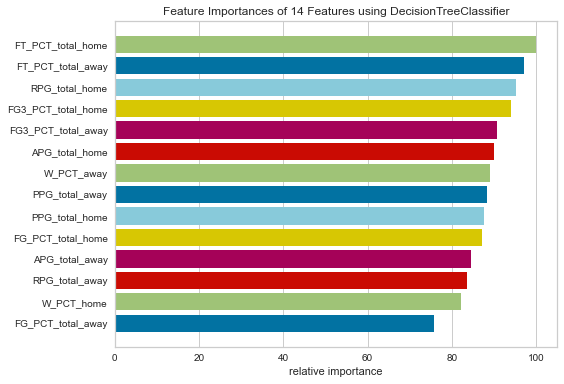

---------------------------------------------
i=2


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': 'balanced'}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.55      0.55      2727
           1       0.55      0.54      0.54      2757

    accuracy                           0.54      5484
   macro avg       0.54      0.54      0.54      5484
weighted avg       0.54      0.54      0.54      5484



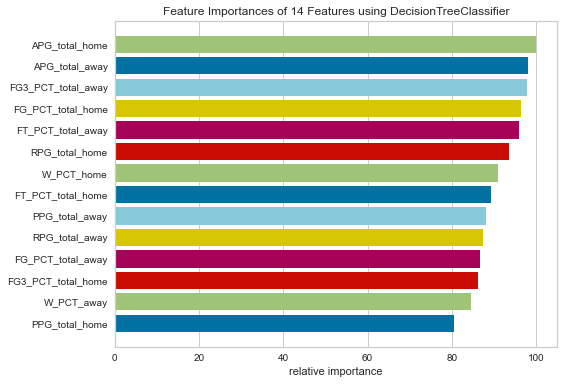

---------------------------------------------
i=3


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      2715
           1       0.55      0.54      0.54      2768

    accuracy                           0.54      5483
   macro avg       0.54      0.54      0.54      5483
weighted avg       0.54      0.54      0.54      5483



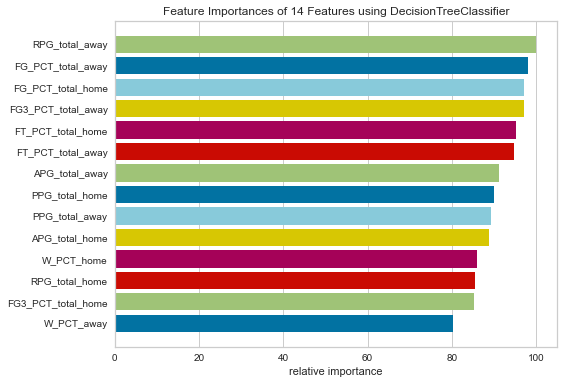

---------------------------------------------
i=4


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


WINNER:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.54
              precision    recall  f1-score   support

           0       0.55      0.56      0.55      2792
           1       0.54      0.53      0.53      2691

    accuracy                           0.54      5483
   macro avg       0.54      0.54      0.54      5483
weighted avg       0.54      0.54      0.54      5483



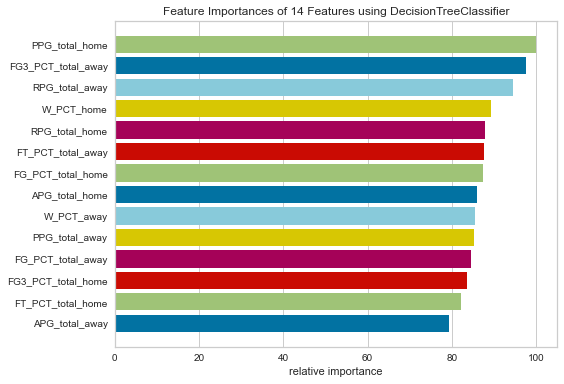

---------------------------------------------
Mean accuracy: 0.5493044827371067
Max accuracy: 0.5594456601021153
Min accuracy: 0.5431333211745395
i=5


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.52      0.53      2614
           1       0.51      0.51      0.51      2495

    accuracy                           0.52      5109
   macro avg       0.52      0.52      0.52      5109
weighted avg       0.52      0.52      0.52      5109



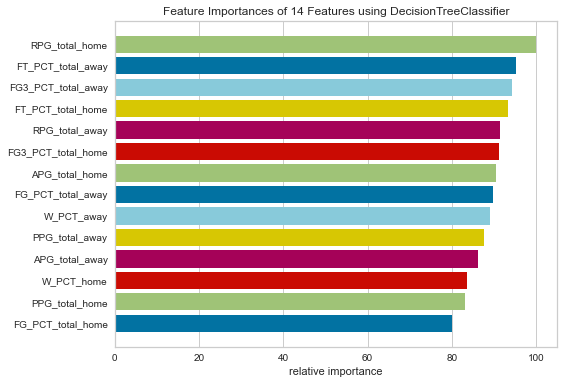

---------------------------------------------
i=6


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.52      0.53      2571
           1       0.52      0.53      0.52      2538

    accuracy                           0.52      5109
   macro avg       0.52      0.52      0.52      5109
weighted avg       0.52      0.52      0.52      5109



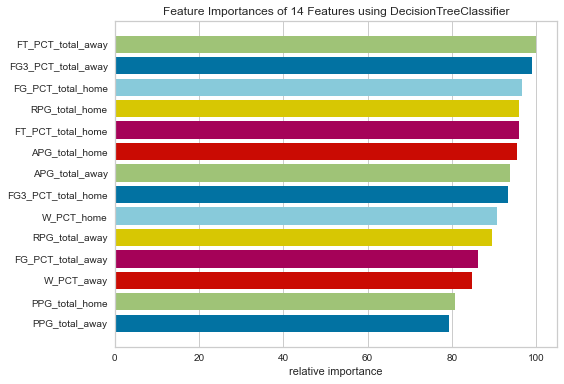

---------------------------------------------
i=7


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2559
           1       0.53      0.52      0.52      2549

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



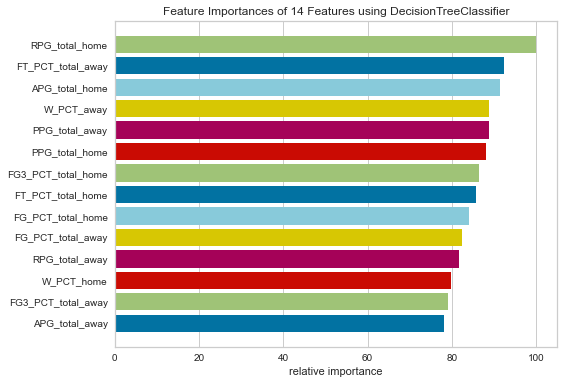

---------------------------------------------
i=8


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': None}): 0.53
              precision    recall  f1-score   support

           0       0.52      0.53      0.53      2470
           1       0.55      0.53      0.54      2638

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



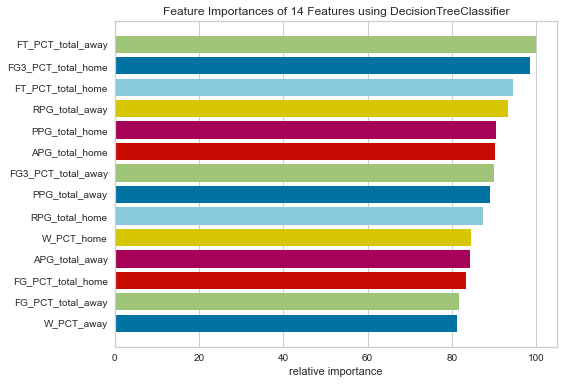

---------------------------------------------
i=9


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FGP:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': None}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2557
           1       0.53      0.53      0.53      2551

    accuracy                           0.53      5108
   macro avg       0.53      0.53      0.53      5108
weighted avg       0.53      0.53      0.53      5108



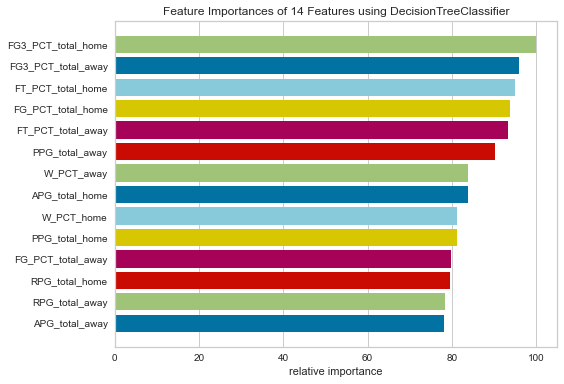

---------------------------------------------
Mean accuracy: 0.5272101277506659
Max accuracy: 0.5340642129992169
Min accuracy: 0.5177138383245253
i=10


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      2365
           1       0.50      0.50      0.50      2346

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



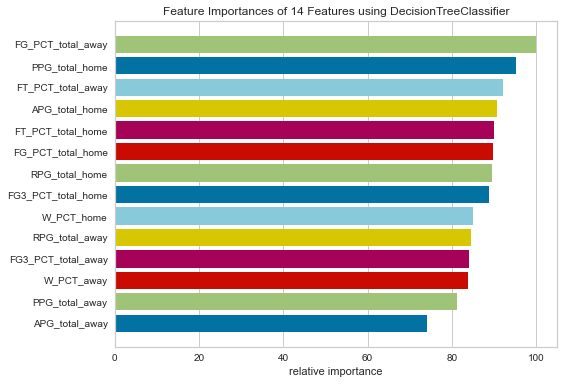

---------------------------------------------
i=11


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.50
              precision    recall  f1-score   support

           0       0.51      0.49      0.50      2402
           1       0.50      0.52      0.50      2309

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.51      0.50      0.50      4711



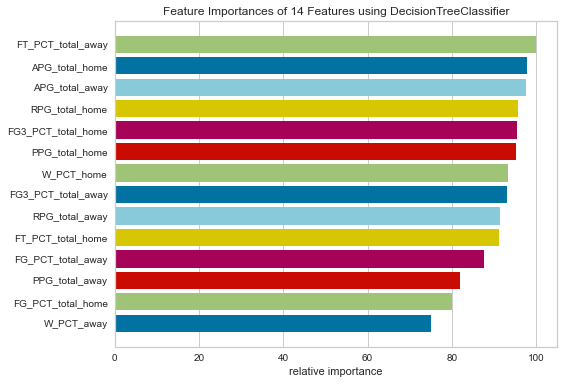

---------------------------------------------
i=12


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.50
              precision    recall  f1-score   support

           0       0.48      0.51      0.49      2284
           1       0.51      0.49      0.50      2427

    accuracy                           0.50      4711
   macro avg       0.50      0.50      0.50      4711
weighted avg       0.50      0.50      0.50      4711



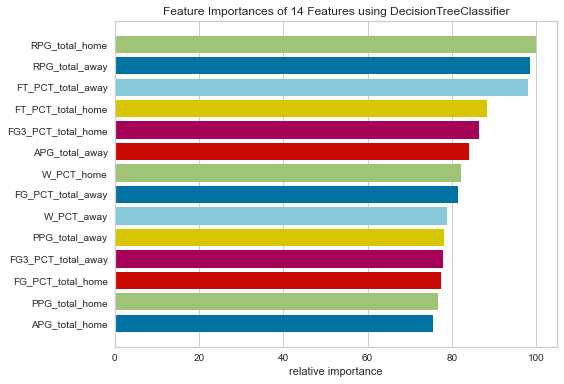

---------------------------------------------
i=13


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': 'balanced'}): 0.51
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      2307
           1       0.52      0.51      0.52      2404

    accuracy                           0.51      4711
   macro avg       0.51      0.51      0.51      4711
weighted avg       0.51      0.51      0.51      4711



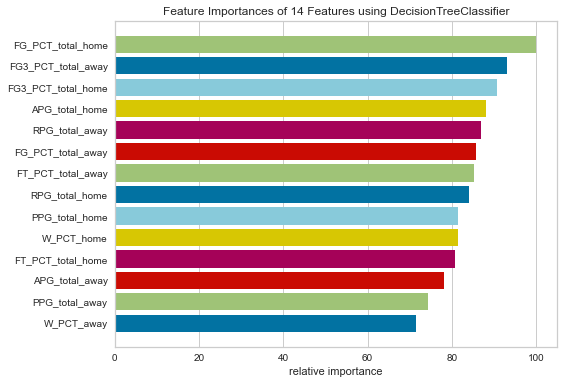

---------------------------------------------
i=14


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FG3:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.51
              precision    recall  f1-score   support

           0       0.52      0.48      0.50      2419
           1       0.49      0.53      0.51      2291

    accuracy                           0.51      4710
   macro avg       0.51      0.51      0.51      4710
weighted avg       0.51      0.51      0.51      4710



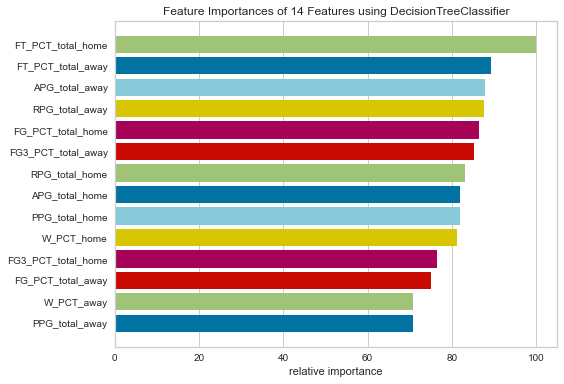

---------------------------------------------
Mean accuracy: 0.503077902780726
Max accuracy: 0.5115686690723837
Min accuracy: 0.4962852897473997
i=15


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': None}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      2337
           1       0.50      0.52      0.51      2345

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



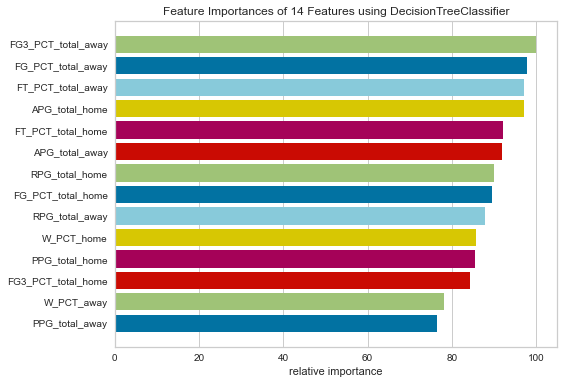

---------------------------------------------
i=16


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': None}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2322
           1       0.51      0.50      0.50      2360

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



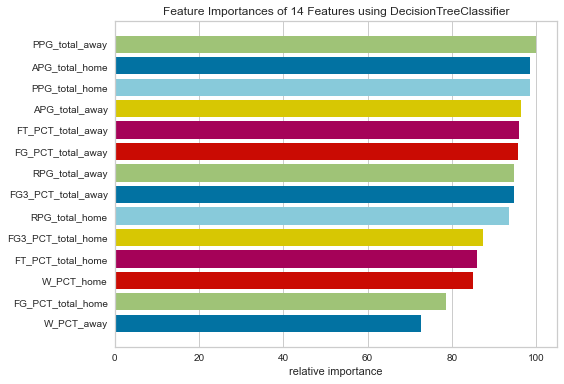

---------------------------------------------
i=17


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      2360
           1       0.51      0.51      0.51      2322

    accuracy                           0.51      4682
   macro avg       0.51      0.51      0.51      4682
weighted avg       0.51      0.51      0.51      4682



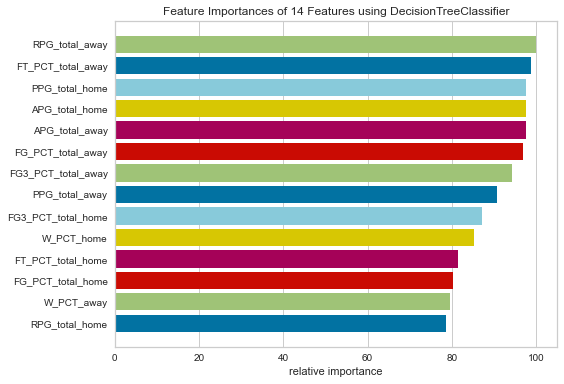

---------------------------------------------
i=18


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2343
           1       0.50      0.50      0.50      2339

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



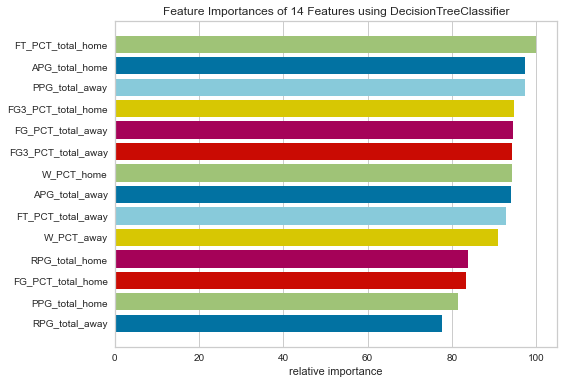

---------------------------------------------
i=19


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


FT:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.50
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      2343
           1       0.50      0.49      0.50      2339

    accuracy                           0.50      4682
   macro avg       0.50      0.50      0.50      4682
weighted avg       0.50      0.50      0.50      4682



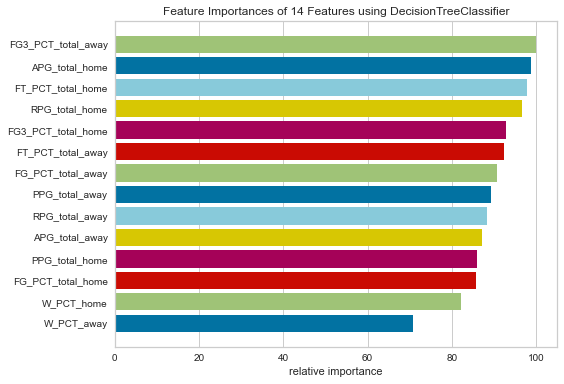

---------------------------------------------
Mean accuracy: 0.5041114908158907
Max accuracy: 0.5102520290474156
Min accuracy: 0.49914566424604867
i=20


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.54
              precision    recall  f1-score   support

           0       0.54      0.53      0.54      2556
           1       0.53      0.54      0.54      2540

    accuracy                           0.54      5096
   macro avg       0.54      0.54      0.54      5096
weighted avg       0.54      0.54      0.54      5096



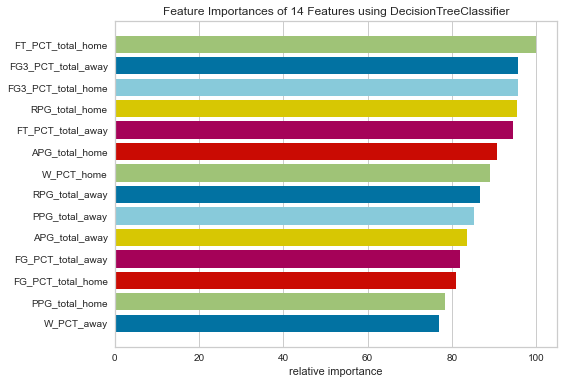

---------------------------------------------
i=21


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.53
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      2578
           1       0.53      0.53      0.53      2517

    accuracy                           0.53      5095
   macro avg       0.53      0.53      0.53      5095
weighted avg       0.53      0.53      0.53      5095



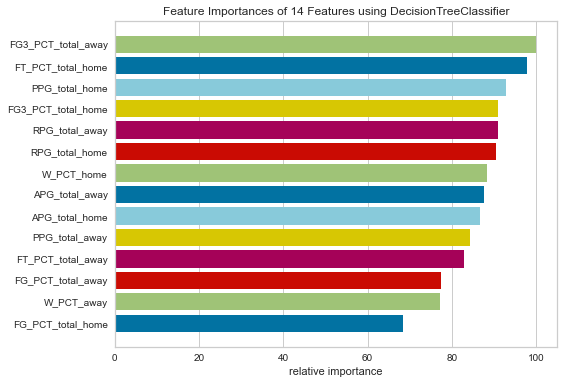

---------------------------------------------
i=22


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': None}): 0.54
              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2522
           1       0.55      0.53      0.54      2573

    accuracy                           0.54      5095
   macro avg       0.54      0.54      0.54      5095
weighted avg       0.54      0.54      0.54      5095



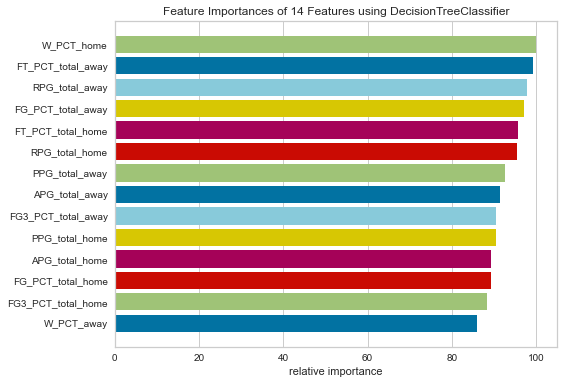

---------------------------------------------
i=23


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': 'balanced'}): 0.54
              precision    recall  f1-score   support

           0       0.53      0.54      0.54      2531
           1       0.54      0.53      0.54      2564

    accuracy                           0.54      5095
   macro avg       0.54      0.54      0.54      5095
weighted avg       0.54      0.54      0.54      5095



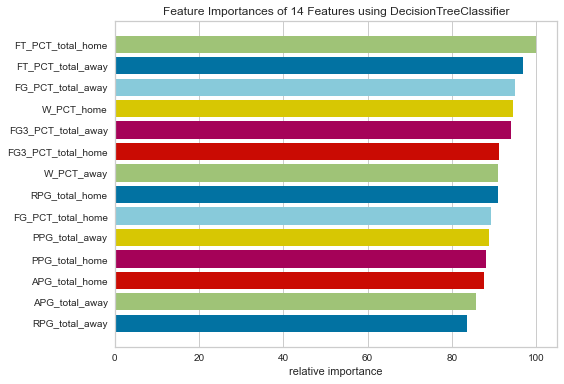

---------------------------------------------
i=24


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


AST:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.51      0.51      2551
           1       0.51      0.52      0.52      2544

    accuracy                           0.52      5095
   macro avg       0.52      0.52      0.52      5095
weighted avg       0.52      0.52      0.52      5095



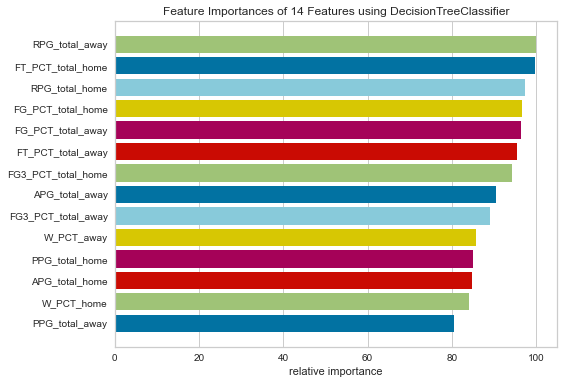

---------------------------------------------
Mean accuracy: 0.53628382167391
Max accuracy: 0.5389597644749755
Min accuracy: 0.534838076545633
i=25


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.53
              precision    recall  f1-score   support

           0       0.53      0.52      0.52      2470
           1       0.53      0.54      0.53      2475

    accuracy                           0.53      4945
   macro avg       0.53      0.53      0.53      4945
weighted avg       0.53      0.53      0.53      4945



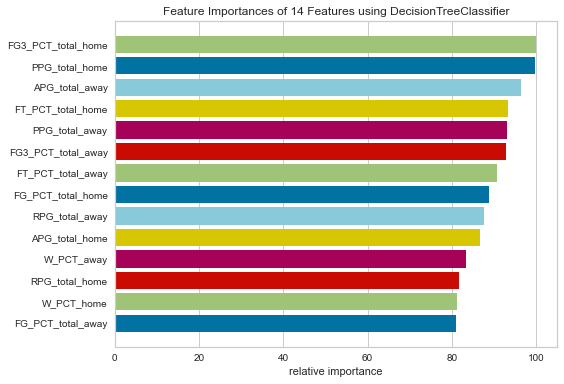

---------------------------------------------
i=26


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': 'balanced'}): 0.51
              precision    recall  f1-score   support

           0       0.49      0.54      0.51      2413
           1       0.52      0.48      0.50      2532

    accuracy                           0.51      4945
   macro avg       0.51      0.51      0.51      4945
weighted avg       0.51      0.51      0.51      4945



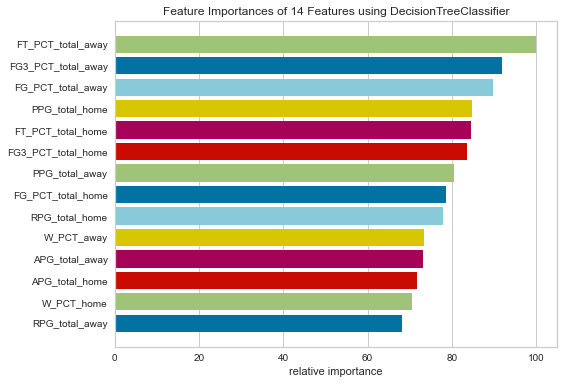

---------------------------------------------
i=27


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'gini', 'class_weight': None}): 0.52
              precision    recall  f1-score   support

           0       0.52      0.52      0.52      2479
           1       0.51      0.51      0.51      2465

    accuracy                           0.52      4944
   macro avg       0.52      0.52      0.52      4944
weighted avg       0.52      0.52      0.52      4944



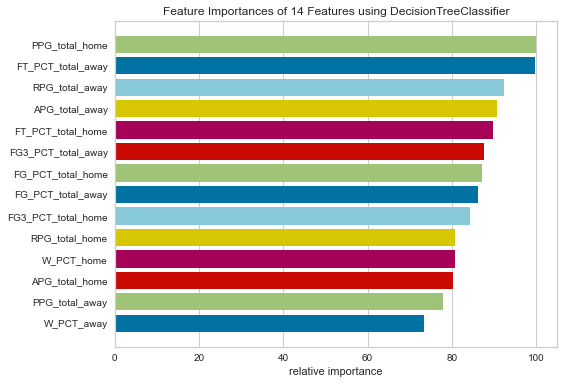

---------------------------------------------
i=28


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': 'balanced'}): 0.51
              precision    recall  f1-score   support

           0       0.51      0.52      0.51      2473
           1       0.51      0.50      0.50      2471

    accuracy                           0.51      4944
   macro avg       0.51      0.51      0.51      4944
weighted avg       0.51      0.51      0.51      4944



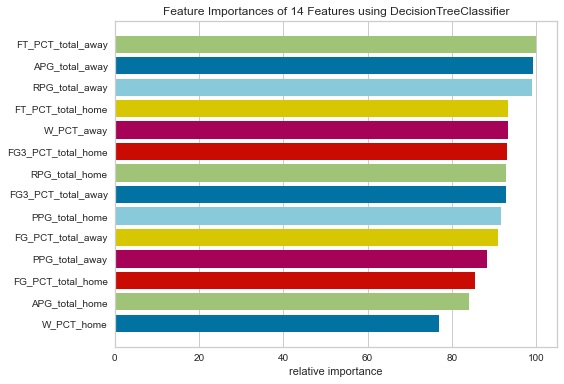

---------------------------------------------
i=29


c:\users\philip\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


REB:

Best decision tree accuracy ({'criterion': 'entropy', 'class_weight': 'balanced'}): 0.52
              precision    recall  f1-score   support

           0       0.53      0.51      0.52      2526
           1       0.51      0.53      0.52      2418

    accuracy                           0.52      4944
   macro avg       0.52      0.52      0.52      4944
weighted avg       0.52      0.52      0.52      4944



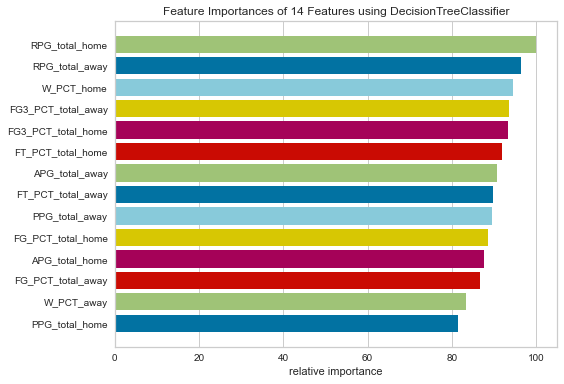

---------------------------------------------
Mean accuracy: 0.5140051386448343
Max accuracy: 0.5282103134479272
Min accuracy: 0.5060679611650486


In [32]:
# print_all_metrics_and_plot(
#     DecisionTreeClassifier(random_state=0),
#     X_train_dict,
#     X_test_dict,
#     {
#         'class_weight': ['balanced', None],
#         'criterion': ['gini', 'entropy'],
#     },
# )
print_cross_validated_and_plot(X_train_dicts, X_test_dicts, y_train_dicts, y_test_dicts, {
    'class_weight': ['balanced', None],
    'criterion': ['gini', 'entropy'],
})

## Try w/ diffrent random_state

In [33]:
print_all_metrics_and_plot(
    DecisionTreeClassifier(random_state=1234),
    X_train_dict,
    X_test_dict,
    {
        'max_depth': [*range(4,35)],
        'criterion': ['gini', 'entropy'],
    },
)

TypeError: print_all_metrics_and_plot() missing 2 required positional arguments: 'y_test_dict' and 'grid_cv_params'

In [ ]:
print_all_metrics_and_plot(
    DecisionTreeClassifier(random_state=76634),
    X_train_dict,
    X_test_dict,
    {
        'max_leaf_nodes': [*range(4,60)],
        'criterion': ['gini', 'entropy'],
    },
)